## SFN 24 Replication

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

2024-10-03 15:04:24.860307: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-03 15:04:26.691422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 15:04:28.699039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from metrics import * 
from sim import *
from sim import multi_sim_run
from sim import plot

In [4]:
# overall imports
import importlib
import data

# data load
importlib.reload(data.data_load)
from data.data_load import load_transcriptome, load_connectome
importlib.reload(data.data_load)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# prebuilt model classes
import models.prebuilt_models
from models.prebuilt_models import ModelBuild
importlib.reload(models.prebuilt_models)

# metric classes
import metrics.distance_FC
import metrics.eval
from metrics.eval import ModelEvaluator
from metrics.eval import pearson_numpy, mse_numpy, r2_numpy, pearson_cupy, mse_cupy, r2_cupy
importlib.reload(metrics.eval)

# sim class
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
import sim.multi_sim_run
from sim.sim import Simulation
from sim.multi_sim_run import multi_sim_run, single_sim_run, open_pickled_results, combine_results
importlib.reload(sim.sim)
importlib.reload(sim.sim_utils)
importlib.reload(sim.multi_sim_run)

import sim.plot
from sim.plot import (
    plot_predictions, 
    barplot_model_performance,
    boxplot_model_performance,
    plot_predictions_with_metrics,
    plot_best_params_table, plot_best_parameters_table_colored, 
    violin_plot_model_performance, 
    plot_transcriptome_performance_bar, plot_connectome_performance_bar, 
    plot_combined_performance_bar
)

importlib.reload(sim.plot)


<module 'sim.plot' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/plot.py'>

#### Check job specs

In [5]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.showUtilization()


CPU Usage: 13.7%
RAM Usage: 11.1%
Available RAM: 335.1G
Total RAM: 377.1G
52.4G


RuntimeError: Could not find an available GPU after 1 attempts with 900 seconds interval.

## Table of Contents
- [Multidataset PLS](#PLS)
    - [AHBA+HCP](#AHBA)
    - [GTEx+HCP](#GTEx)
    - [UTSW+HCP](#UTSW)
- [AHBA+HCP](#AHBA)
    - [Bilinear PLS](#PLS-Sims)
      - [Random Splits](#PLS-Random-Splits)
    - [XGBoost](#XGBoost-Sims)
      - [Random Splits](#XGBoost-Random-Splits)

### Multidataset PLS

#### AHBA

In [5]:
X = load_transcriptome(dataset='AHBA')
Y = load_connectome(dataset='AHBA')

In [6]:
def fit_pls(X, Y, n_components):
    """Fit PLS model with specified number of components and return variance explained."""
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)

    # Predict on the training set
    Y_pred = pls.predict(X)

    # Calculate R² (variance explained) on the training set
    variance_explained = r2_score(Y, Y_pred)

    return pls, variance_explained

In [7]:
def run_pls_for_components(X, Y, max_components=20):
    """Fit PLS for multiple components and gather variance explained."""
    variances_explained = []

    # Fit PLS for each number of components
    for n_components in range(1, max_components + 1):
        _, variance_explained = fit_pls(X, Y, n_components)
        variances_explained.append(variance_explained)
        print(f"Components: {n_components}, Variance explained: {variance_explained}")

    return variances_explained


In [8]:

def plot_variance_explained(variances_explained, max_components=20):
    """Plot number of components vs variance explained."""
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_components + 1), variances_explained, label='Variance Explained (R²)', marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained (R²)')
    plt.title('Number of Components vs Variance Explained')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
def load_ahba_gene_names(file_name='allgenes_stable_r0.2_schaefer_100.csv'):
    """
    Load gene names from a CSV file.
    
    Parameters:
    file_name (str): The CSV file name containing gene names.
    
    Returns:
    np.ndarray: Array of gene names.
    """
    relative_data_path = os.path.normpath(os.getcwd() + os.sep + os.pardir)    
    gene_file_path = os.path.join(relative_data_path, 'GeneEx2Conn/data', 'enigma', file_name)
    
    schaefer114_genes = pd.read_csv(gene_file_path)
    schaefer114_genes.set_index('label', inplace=True)
    gene_names = np.array(schaefer114_genes.columns.tolist())
    
    print(f'Loaded {len(gene_names)} gene names.')
    return gene_names

def load_gtex_gene_names(file_name='RxG_data_gtex_mean_gtex_ahba_space.csv'):
    relative_data_path = os.path.normpath(os.getcwd() + os.sep + os.pardir)    
    gene_file_path = os.path.join(relative_data_path, 'data/region_map_pickles', file_name)
    
    schaefer114_genes = pd.read_csv(gene_file_path)
    schaefer114_genes.set_index('region', inplace=True)
    gene_names = np.array(schaefer114_genes.columns.tolist())
    
    print(f'Loaded {len(gene_names)} gene names.')
    return gene_names

def load_utsw_gene_names(file_name='RxG_data_utsmc_mean_ahba_utsmc_space.csv'):
    relative_data_path = os.path.normpath(os.getcwd() + os.sep + os.pardir)    
    gene_file_path = os.path.join(relative_data_path, 'data/region_map_pickles', file_name)
    
    schaefer114_genes = pd.read_csv(gene_file_path)
    schaefer114_genes.set_index('region', inplace=True)
    gene_names = np.array(schaefer114_genes.columns.tolist())
    
    print(f'Loaded {len(gene_names)} gene names.')
    return gene_names
import pandas as pd
from sklearn.cross_decomposition import PLSRegression

def get_feature_importances(X, Y, n_components=3, gene_names=None):
    """
    Fit PLS and return a DataFrame of gene weights for the first n components.
    
    Parameters:
    X (ndarray): The transcriptome data (samples x genes).
    Y (ndarray): The connectome data (samples x regions).
    n_components (int): Number of components to extract from PLS.
    gene_names (list or ndarray): List or array of gene names corresponding to X's columns.
    
    Returns:
    pd.DataFrame: A DataFrame of gene weights (rows: genes, columns: components).
    """
    # Fit PLS model
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)

    # Get weights for the first n components
    weights = pls.x_weights_[:, :n_components]

    # If no gene names are provided, default to numeric indices
    if gene_names is None:
        gene_names = np.arange(0, X.shape[1], 1)

    # Create a DataFrame of feature importances (genes by component weights)
    feature_importances_df = pd.DataFrame(weights, index=gene_names, columns=[f'Component_{i+1}' for i in range(n_components)])
    
    return feature_importances_df

    
def normalize_components(df):
    """Normalize each component column to have values between 0 and 1."""
    normalized_df = df.copy()
    
    for column in normalized_df.columns:
        min_val = normalized_df[column].min()
        max_val = normalized_df[column].max()
        
        # Normalize to the range [0, 1]
        normalized_df[column] = (normalized_df[column] - min_val) / (max_val - min_val)
    
    return normalized_df


In [10]:
load_ahba_gene_names()

Loaded 11053 gene names.


array(['A1BG', 'A1BG-AS1', 'AAAS', ..., 'ZYX', 'ZZEF1', 'ZZZ3'],
      dtype='<U21')

In [11]:
load_gtex_gene_names()

Loaded 10704 gene names.


array(['TUBG2', 'NUDCD3', 'PTPN12', ..., 'DUSP3', 'CCDC120', 'NT5C2'],
      dtype='<U18')

In [12]:
load_utsw_gene_names()

Loaded 10005 gene names.


array(['RABGGTA', 'CLDN5', 'MED8', ..., 'NKAIN2', 'EML6', 'CMTM8'],
      dtype='<U16')

In [13]:
def compute_gene_name_intersection():
    """Compute the intersection of gene names from AHBA, GTEx, and UTSW datasets."""
    
    # Load gene names from each dataset
    ahba_gene_names = load_ahba_gene_names()
    gtex_gene_names = load_gtex_gene_names()
    utsw_gene_names = load_utsw_gene_names()
    
    # Convert to sets for easy intersection
    ahba_set = set(ahba_gene_names)
    gtex_set = set(gtex_gene_names)
    utsw_set = set(utsw_gene_names)
    
    # Compute the intersection of the three sets
    intersected_genes = ahba_set.intersection(gtex_set, utsw_set)
    
    print(f"Number of intersected genes: {len(intersected_genes)}")
    
    # Convert the result back to a sorted list or array
    intersected_gene_names = sorted(intersected_genes)
    
    return intersected_gene_names

# Example of using the function:
intersected_genes = compute_gene_name_intersection()


Loaded 11053 gene names.
Loaded 10704 gene names.
Loaded 10005 gene names.
Number of intersected genes: 9888


Components: 1, Variance explained: 0.17269528617251495
Components: 2, Variance explained: 0.2382253906932577
Components: 3, Variance explained: 0.2893838391109028
Components: 4, Variance explained: 0.36001005091476046
Components: 5, Variance explained: 0.3894282517782608
Components: 6, Variance explained: 0.4194429962282351
Components: 7, Variance explained: 0.4512820187322228
Components: 8, Variance explained: 0.47556418904104125
Components: 9, Variance explained: 0.5195969847997496
Components: 10, Variance explained: 0.5577210134082744


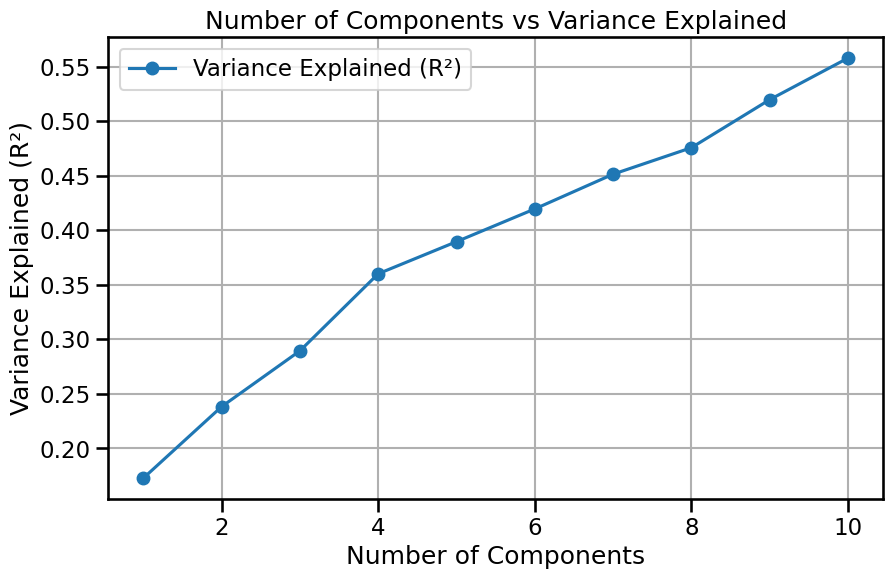

Loaded 11053 gene names.


In [14]:
# Step 1: Load the data
X = load_transcriptome(dataset='AHBA')
Y = load_connectome(dataset='AHBA')

# Step 2: Run PLS for multiple components and get variance explained
max_components = 10
variances_explained = run_pls_for_components(X, Y, max_components)

# Step 3: Plot the number of components vs variance explained
plot_variance_explained(variances_explained, max_components)

ahba_feature_importances_df = get_feature_importances(X, Y, n_components=3, gene_names=load_ahba_gene_names())
ahba_normalized_importances_df = normalize_components(ahba_feature_importances_df)

In [15]:
ahba_feature_importances_df

,Component_1,Component_2,Component_3
A1BG,-0.010853,0.010779,0.008289
A1BG-AS1,0.011132,0.008183,0.011174
AAAS,0.008836,-0.009938,0.000574
AACS,0.013549,0.006949,0.002022
AADAT,0.008383,-0.001006,0.011122
...,...,...,...
ZXDC,-0.011107,-0.005067,-0.004756
ZYG11B,0.013243,0.005303,0.005364
ZYX,0.015577,-0.004292,-0.002192
ZZEF1,0.006778,-0.022955,0.003380


#### GTEx

Components: 1, Variance explained: 0.13696402626343804
Components: 2, Variance explained: 0.3299616450870909
Components: 3, Variance explained: 0.4321768911529551
Components: 4, Variance explained: 0.565359354539021
Components: 5, Variance explained: 0.7036924398359168
Components: 6, Variance explained: 0.8691477479821343
Components: 7, Variance explained: 1.0
Components: 8, Variance explained: 1.0
Components: 9, Variance explained: 1.0
Components: 10, Variance explained: 1.0


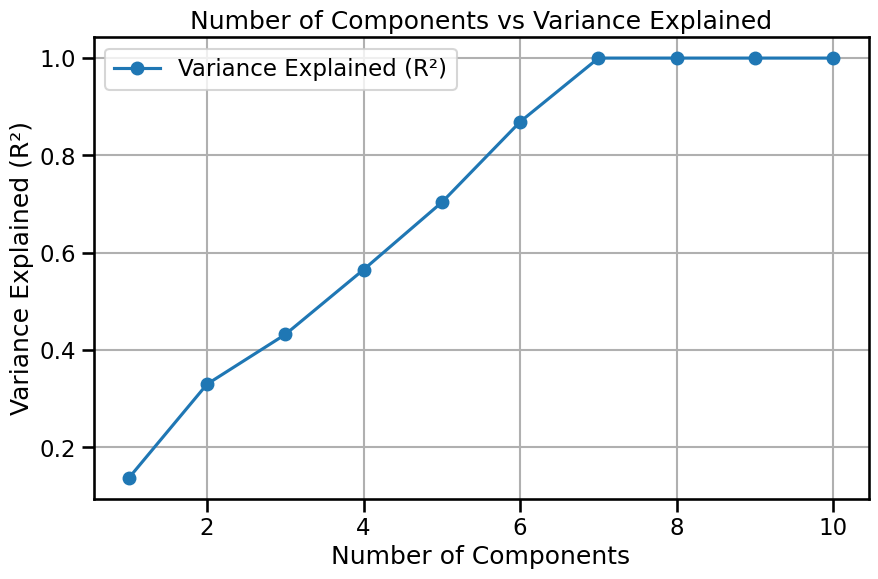

Loaded 10704 gene names.


In [16]:
X = load_transcriptome(dataset='GTEx')
Y = load_connectome(dataset='GTEx')

# Step 2: Run PLS for multiple components and get variance explained
max_components = 10
variances_explained = run_pls_for_components(X, Y, max_components)

# Step 3: Plot the number of components vs variance explained
plot_variance_explained(variances_explained, max_components)

gtex_feature_importances_df = get_feature_importances(X, Y, n_components=3, gene_names=load_gtex_gene_names())
gtex_normalized_importances_df = normalize_components(gtex_feature_importances_df)

In [17]:
gtex_feature_importances_df

,Component_1,Component_2,Component_3
TUBG2,0.011459,0.001647,0.008237
NUDCD3,0.011851,-0.002469,-0.002825
PTPN12,0.011284,-0.012088,-0.000845
TMEM87A,-0.004238,-0.017873,-0.011441
DPP10-AS1,0.011630,0.004457,0.004691
...,...,...,...
B4GALT5,0.013567,-0.000041,-0.002555
CRIP2,0.010576,0.011370,0.002650
DUSP3,0.012433,0.001158,0.006054
CCDC120,0.008681,0.013625,0.003696


#### UTSW

Components: 1, Variance explained: 0.14416221888628505
Components: 2, Variance explained: 0.2609250598681544
Components: 3, Variance explained: 0.37723598294978933
Components: 4, Variance explained: 0.5176886615079771
Components: 5, Variance explained: 0.6500272446030027
Components: 6, Variance explained: 0.7525941375253418
Components: 7, Variance explained: 0.87189800296156
Components: 8, Variance explained: 0.961949087518129
Components: 9, Variance explained: 0.9999999517062186
Components: 10, Variance explained: 1.0


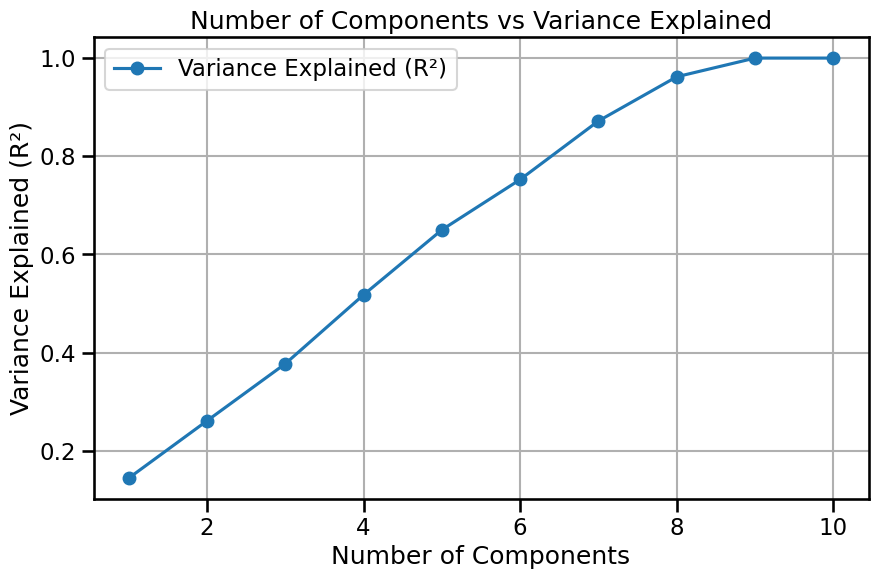

Loaded 10005 gene names.


In [18]:
X = load_transcriptome(dataset='UTSW')
Y = load_connectome(dataset='UTSW')

# Step 2: Run PLS for multiple components and get variance explained
max_components = 10
variances_explained = run_pls_for_components(X, Y, max_components)

# Step 3: Plot the number of components vs variance explained
plot_variance_explained(variances_explained, max_components)

utsw_feature_importances_df = get_feature_importances(X, Y, n_components=3, gene_names=load_utsw_gene_names())
utsw_normalized_importances_df = normalize_components(utsw_feature_importances_df)

In [19]:
utsw_feature_importances_df

,Component_1,Component_2,Component_3
RABGGTA,0.014430,-0.008812,0.002349
CLDN5,-0.009901,0.009492,-0.010605
MED8,0.002003,0.003133,-0.003404
CALHM6,0.010912,0.007263,0.017946
AFF2,-0.001145,-0.000315,-0.016722
...,...,...,...
ZBTB18,0.009447,0.000673,0.020541
NAGLU,-0.015241,0.004246,0.002151
NKAIN2,0.001257,0.001369,0.017613
EML6,0.006124,-0.006054,0.010777


#### Evaluate PLS similarity across datasets

In [93]:
# PLS ANALYSIS HELPER FUNCS
def filter_and_sort_by_genes(df, intersected_genes):
    """
    Filter the DataFrame to include only intersecting genes and sort alphabetically.
    
    Parameters:
    df (pd.DataFrame): The feature importance DataFrame.
    intersected_genes (list or ndarray): List or array of intersecting gene names.
    
    Returns:
    pd.DataFrame: Filtered and sorted DataFrame.
    """
    # Filter the DataFrame to include only the intersecting genes
    filtered_df = df.loc[intersected_genes]

    # Sort the DataFrame alphabetically by gene names
    filtered_df = filtered_df.sort_index()

    return filtered_df

from scipy.stats import spearmanr, pearsonr, kendalltau

def compute_correlation(df1, df2, correlation_type='spearman', use_abs=False):
    """
    Compute the correlation matrix between the components of two DataFrames.
    
    Parameters:
    df1 (pd.DataFrame): The first DataFrame (e.g., AHBA feature importance).
    df2 (pd.DataFrame): The second DataFrame (e.g., GTEx or UTSW feature importance).
    correlation_type (str): The type of correlation to use ('spearman', 'pearson', 'kendall').
    use_abs (bool): Whether to use the absolute values of the weights for correlation.
    
    Returns:
    pd.DataFrame: A correlation matrix (components from df1 vs df2).
    """
    # Optionally take the absolute values of the weights
    if use_abs:
        df1 = df1.abs()
        df2 = df2.abs()

    # Initialize an empty correlation matrix
    n_components_df1 = df1.shape[1]
    n_components_df2 = df2.shape[1]
    correlation_matrix = np.zeros((n_components_df1, n_components_df2))

    # Choose the correlation function
    def get_correlation_func(correlation_type):
        if correlation_type == 'spearman':
            return spearmanr
        elif correlation_type == 'pearson':
            return pearsonr
        elif correlation_type == 'kendall':
            return kendalltau
        else:
            raise ValueError("Invalid correlation type. Choose 'spearman', 'pearson', or 'kendall'.")

    correlation_func = get_correlation_func(correlation_type)

    # Compute correlation between each pair of components
    for i in range(n_components_df1):
        for j in range(n_components_df2):
            # Correlation between df1 component i and df2 component j
            corr, _ = correlation_func(df1.iloc[:, i], df2.iloc[:, j])
            correlation_matrix[i, j] = corr

    # Convert to DataFrame for easier handling and labeling
    correlation_df = pd.DataFrame(correlation_matrix, 
                                  index=[f'{df1.columns[i]}' for i in range(n_components_df1)], 
                                  columns=[f'{df2.columns[j]}' for j in range(n_components_df2)])

    return correlation_df
    
def compute_correlation_with_labels(df1, df2, dataset1_name='AHBA', dataset2_name='GTEx', correlation_type='spearman', use_abs=False):
    """
    Compute the correlation matrix between the components of two DataFrames and label axes with dataset names.

    Parameters:
    df1 (pd.DataFrame): The first DataFrame (e.g., AHBA feature importance).
    df2 (pd.DataFrame): The second DataFrame (e.g., GTEx feature importance).
    dataset1_name (str): The name of the first dataset (for axis labeling).
    dataset2_name (str): The name of the second dataset (for axis labeling).
    correlation_type (str): The type of correlation to use ('spearman', 'pearson', 'kendall').
    use_abs (bool): Whether to use the absolute values of the weights for correlation.

    Returns:
    pd.DataFrame: A correlation matrix (components from df1 vs df2) with labeled axes.
    """
    # Optionally take the absolute values of the weights
    if use_abs:
        df1 = df1.abs()
        df2 = df2.abs()

    # Initialize an empty correlation matrix
    n_components_df1 = df1.shape[1]
    n_components_df2 = df2.shape[1]
    correlation_matrix = np.zeros((n_components_df1, n_components_df2))

    # Choose the correlation function
    def get_correlation_func(correlation_type):
        if correlation_type == 'spearman':
            return spearmanr
        elif correlation_type == 'pearson':
            return pearsonr
        elif correlation_type == 'kendall':
            return kendalltau
        else:
            raise ValueError("Invalid correlation type. Choose 'spearman', 'pearson', or 'kendall'.")

    correlation_func = get_correlation_func(correlation_type)

    # Compute correlation between each pair of components
    for i in range(n_components_df1):
        for j in range(n_components_df2):
            # Correlation between df1 component i and df2 component j
            corr, _ = correlation_func(df1.iloc[:, i], df2.iloc[:, j])
            correlation_matrix[i, j] = corr

    # Add dataset-specific labels to the rows and columns
    df1_labels = [f'{dataset1_name}_Component_{i+1}' for i in range(n_components_df1)]
    df2_labels = [f'{dataset2_name}_Component_{i+1}' for i in range(n_components_df2)]

    # Convert to DataFrame for easier handling and labeling
    correlation_df = pd.DataFrame(correlation_matrix, index=df1_labels, columns=df2_labels)

    return correlation_df

def compute_correlation_with_pvalues(df1, df2, dataset1_name='AHBA', dataset2_name='GTEx', correlation_type='spearman', use_abs=False):
    """
    Compute the correlation matrix and p-values between the components of two DataFrames and label axes with dataset names.

    Parameters:
    df1 (pd.DataFrame): The first DataFrame (e.g., AHBA feature importance).
    df2 (pd.DataFrame): The second DataFrame (e.g., GTEx feature importance).
    dataset1_name (str): The name of the first dataset (for axis labeling).
    dataset2_name (str): The name of the second dataset (for axis labeling).
    correlation_type (str): The type of correlation to use ('spearman', 'pearson', 'kendall').
    use_abs (bool): Whether to use the absolute values of the weights for correlation.

    Returns:
    pd.DataFrame: A p-value matrix (components from df1 vs df2) with labeled axes.
    """
    # Optionally take the absolute values of the weights
    if use_abs:
        df1 = df1.abs()
        df2 = df2.abs()

    # Initialize an empty p-value matrix
    n_components_df1 = df1.shape[1]
    n_components_df2 = df2.shape[1]
    pvalue_matrix = np.zeros((n_components_df1, n_components_df2))

    # Choose the correlation function
    def get_correlation_func(correlation_type):
        if correlation_type == 'spearman':
            return spearmanr
        elif correlation_type == 'pearson':
            return pearsonr
        elif correlation_type == 'kendall':
            return kendalltau
        else:
            raise ValueError("Invalid correlation type. Choose 'spearman', 'pearson', or 'kendall'.")

    correlation_func = get_correlation_func(correlation_type)

    # Compute correlation and p-values between each pair of components
    for i in range(n_components_df1):
        for j in range(n_components_df2):
            _, p_value = correlation_func(df1.iloc[:, i], df2.iloc[:, j])
            pvalue_matrix[i, j] = p_value

    # Add dataset-specific labels to the rows and columns
    df1_labels = [f'{dataset1_name}_Component_{i+1}' for i in range(n_components_df1)]
    df2_labels = [f'{dataset2_name}_Component_{i+1}' for i in range(n_components_df2)]

    # Convert to DataFrame for easier handling and labeling
    pvalue_df = pd.DataFrame(pvalue_matrix, index=df1_labels, columns=df2_labels)

    return pvalue_df


def compute_correlation_across_datasets(ahba_df, gtex_df, utsw_df, correlation_type='spearman', use_abs=False):
    """
    Compute the correlation matrix for components across AHBA, GTEx, and UTSW datasets.
    
    Parameters:
    ahba_df (pd.DataFrame): AHBA feature importance DataFrame.
    gtex_df (pd.DataFrame): GTEx feature importance DataFrame.
    utsw_df (pd.DataFrame): UTSW feature importance DataFrame.
    correlation_type (str): The type of correlation to use ('spearman', 'pearson', 'kendall').
    use_abs (bool): Whether to use absolute values of the weights for correlation.
    
    Returns:
    pd.DataFrame: A 9x9 correlation matrix (components from AHBA, GTEx, and UTSW).
    """
    # Optionally take the absolute values of the weights
    if use_abs:
        ahba_df = ahba_df.abs()
        gtex_df = gtex_df.abs()
        utsw_df = utsw_df.abs()

    # Combine all components from the three datasets into one DataFrame
    combined_df = pd.concat([ahba_df, gtex_df, utsw_df], axis=1)

    # Create labels for combined components
    component_labels = ([f'AHBA_Component_{i+1}' for i in range(ahba_df.shape[1])] +
                        [f'GTEx_Component_{i+1}' for i in range(gtex_df.shape[1])] +
                        [f'UTSW_Component_{i+1}' for i in range(utsw_df.shape[1])])

    # Initialize an empty 9x9 correlation matrix
    correlation_matrix = np.zeros((9, 9))

    # Choose the correlation function
    def get_correlation_func(correlation_type):
        if correlation_type == 'spearman':
            return spearmanr
        elif correlation_type == 'pearson':
            return pearsonr
        elif correlation_type == 'kendall':
            return kendalltau
        else:
            raise ValueError("Invalid correlation type. Choose 'spearman', 'pearson', or 'kendall'.")

    correlation_func = get_correlation_func(correlation_type)

    # Compute correlation between each pair of components across datasets
    for i in range(9):
        for j in range(9):
            # Correlation between component i and component j
            corr, _ = correlation_func(combined_df.iloc[:, i], combined_df.iloc[:, j])
            correlation_matrix[i, j] = corr

    # Convert to DataFrame with proper labels
    correlation_df = pd.DataFrame(correlation_matrix, 
                                  index=component_labels, 
                                  columns=component_labels)
    
    return correlation_df

def compute_correlation_pvalues_across_datasets(ahba_df, gtex_df, utsw_df, correlation_type='spearman', use_abs=False):
    """
    Compute the p-value matrix for correlations between components across AHBA, GTEx, and UTSW datasets.
    
    Parameters:
    ahba_df (pd.DataFrame): AHBA feature importance DataFrame.
    gtex_df (pd.DataFrame): GTEx feature importance DataFrame.
    utsw_df (pd.DataFrame): UTSW feature importance DataFrame.
    correlation_type (str): The type of correlation to use ('spearman', 'pearson', 'kendall').
    use_abs (bool): Whether to use the absolute values of the weights for correlation.
    
    Returns:
    pd.DataFrame: A 9x9 p-value matrix (components from AHBA, GTEx, and UTSW).
    """
    # Optionally take the absolute values of the weights
    if use_abs:
        ahba_df = ahba_df.abs()
        gtex_df = gtex_df.abs()
        utsw_df = utsw_df.abs()

    # Combine all components from the three datasets into one DataFrame
    combined_df = pd.concat([ahba_df, gtex_df, utsw_df], axis=1)

    # Create labels for combined components
    component_labels = ([f'AHBA_Component_{i+1}' for i in range(ahba_df.shape[1])] +
                        [f'GTEx_Component_{i+1}' for i in range(gtex_df.shape[1])] +
                        [f'UTSW_Component_{i+1}' for i in range(utsw_df.shape[1])])

    # Initialize an empty 9x9 p-value matrix
    pvalue_matrix = np.zeros((9, 9))

    # Choose the correlation function
    def get_correlation_func(correlation_type):
        if correlation_type == 'spearman':
            return spearmanr
        elif correlation_type == 'pearson':
            return pearsonr
        elif correlation_type == 'kendall':
            return kendalltau
        else:
            raise ValueError("Invalid correlation type. Choose 'spearman', 'pearson', or 'kendall'.")

    correlation_func = get_correlation_func(correlation_type)

    # Compute p-values between each pair of components across datasets
    for i in range(9):
        for j in range(9):
            # Correlation and p-value between component i and component j
            _, p_value = correlation_func(combined_df.iloc[:, i], combined_df.iloc[:, j])
            pvalue_matrix[i, j] = p_value

    # Convert to DataFrame with proper labels
    pvalue_df = pd.DataFrame(pvalue_matrix, 
                             index=component_labels, 
                             columns=component_labels)
    
    return pvalue_df

from statsmodels.stats.multitest import multipletests

def apply_benjamini_hochberg_correction(p_values_df):
    """
    Apply Benjamini-Hochberg correction (FDR) to a DataFrame of p-values.
    
    Parameters:
    p_values_df (pd.DataFrame): DataFrame containing p-values.
    
    Returns:
    pd.DataFrame: DataFrame with FDR-adjusted p-values.
    """
    # Flatten the p-values into a 1D array
    p_values = p_values_df.values.flatten()

    # Apply the Benjamini-Hochberg correction
    _, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

    # Reshape corrected p-values back into the original DataFrame format
    corrected_p_values_df = pd.DataFrame(corrected_p_values.reshape(p_values_df.shape),
                                         index=p_values_df.index,
                                         columns=p_values_df.columns)
    
    return corrected_p_values_df

from statsmodels.stats.multitest import multipletests

def apply_bonferroni_correction(p_values_df):
    """
    Apply Bonferroni correction to a DataFrame of p-values.
    
    Parameters:
    p_values_df (pd.DataFrame): DataFrame containing p-values.
    
    Returns:
    pd.DataFrame: DataFrame with Bonferroni-adjusted p-values.
    """
    # Flatten the p-values into a 1D array
    p_values = p_values_df.values.flatten()

    # Apply the Bonferroni correction
    _, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')

    # Reshape corrected p-values back into the original DataFrame format
    corrected_p_values_df = pd.DataFrame(corrected_p_values.reshape(p_values_df.shape),
                                         index=p_values_df.index,
                                         columns=p_values_df.columns)
    
    return corrected_p_values_df

def plot_correlation_heatmap(correlation_df, title='Correlation Heatmap'):
    """
    Plot a heatmap for the correlation matrix.
    
    Parameters:
    correlation_df (pd.DataFrame): The correlation matrix.
    title (str): The title for the heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"fontsize": 12})
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_pvalue_heatmap(pvalue_df, title='P-value Heatmap'):
    """
    Plot a heatmap for the p-value matrix.
    
    Parameters:
    pvalue_df (pd.DataFrame): The p-value matrix.
    title (str): The title for the heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(pvalue_df, annot=True, cmap='viridis', vmin=0, vmax=0.05, 
                cbar_kws={'label': 'P-value'}, annot_kws={"fontsize": 8})
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def get_top_n_values_per_column(df, n=5):
    """
    Get the top N absolute values for each column in the DataFrame and return the 
    corresponding gene names and values for each component.

    Parameters:
    df (pd.DataFrame): The DataFrame containing component weights (e.g., utsw_feature_importances_df).
    n (int): The number of top values to return for each column.

    Returns:
    dict: A dictionary where each component is a key, and the value is a DataFrame of 
          gene names and corresponding top N values.
    """
    top_n_dict = {}

    for col in df.columns:
        # Sort by absolute values and get the top N values for each column separately
        top_n = df[col].abs().nlargest(n)

        # Store the gene names (index) and their corresponding values in a DataFrame
        top_n_df = pd.DataFrame({
            'Gene': df.loc[top_n.index].index,
            'Value': df.loc[top_n.index, col]
        })

        # Store in the dictionary
        top_n_dict[col] = top_n_df

    return top_n_dict


##### Recompute PLS for AHBA subset into GTEx and UTSW space

In [20]:
X = load_transcriptome(dataset='AHBA in GTEx')
Y = load_connectome(dataset='GTEx')

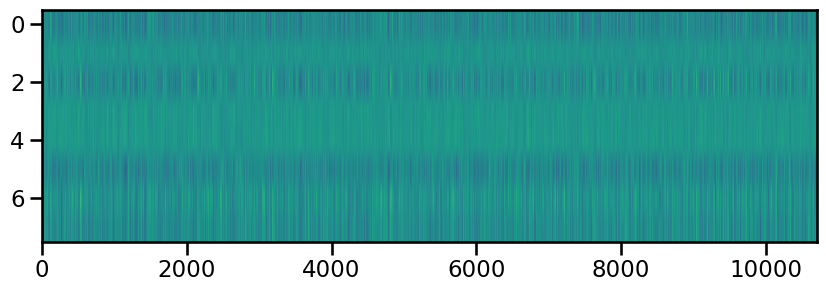

In [24]:
# Increase figure size for better resolution
plt.figure(figsize=(10, 10))  # Increase width and height

# Plot the data
plt.imshow(X, aspect=400)

# Save with high DPI
plt.savefig('ahbagtex_image_large.png', dpi=600)

# Show the plot
plt.show()


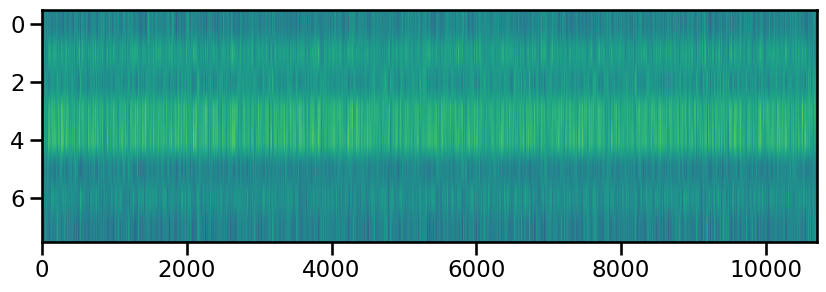

In [25]:
# Increase figure size for better resolution
plt.figure(figsize=(10, 10))  # Increase width and height

# Plot the data
plt.imshow(load_transcriptome(dataset='GTEx'), aspect=400)

# Save with high DPI
plt.savefig('gtex_image_large.png', dpi=600)

# Show the plot
plt.show()

Components: 1, Variance explained: 0.15269521195990893
Components: 2, Variance explained: 0.30090282331476964
Components: 3, Variance explained: 0.4753113504740173
Components: 4, Variance explained: 0.6873425068544686
Components: 5, Variance explained: 0.7564531058252135
Components: 6, Variance explained: 0.9190106735718288
Components: 7, Variance explained: 1.0
Components: 8, Variance explained: 1.0
Components: 9, Variance explained: 1.0
Components: 10, Variance explained: 1.0


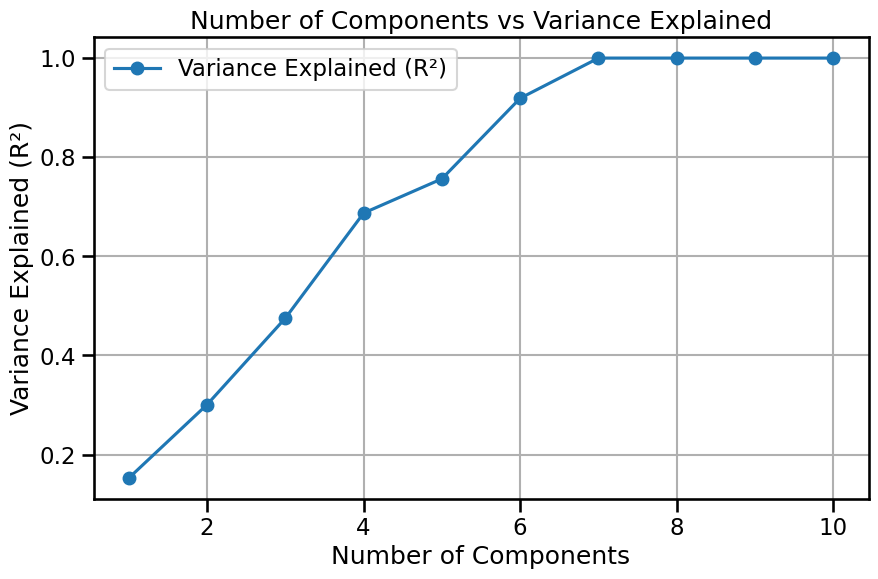

Loaded 10704 gene names.


In [97]:
# Step 2: Run PLS for multiple components and get variance explained
max_components = 10
variances_explained = run_pls_for_components(X, Y, max_components)

# Step 3: Plot the number of components vs variance explained
plot_variance_explained(variances_explained, max_components)

ahba_in_gtex_feature_importances_df = get_feature_importances(X, Y, n_components=3, gene_names=load_gtex_gene_names())
ahba_in_gtex_normalized_importances_df = normalize_components(ahba_in_gtex_feature_importances_df)

In [26]:
X = load_transcriptome(dataset='AHBA in UTSW')
Y = load_connectome(dataset='UTSW')

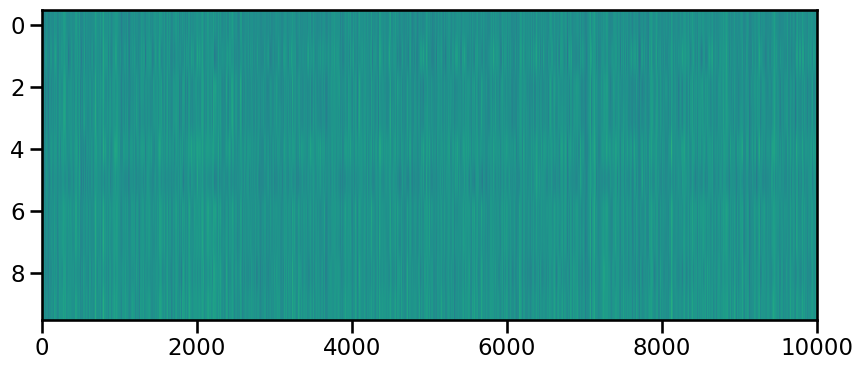

In [27]:
# Increase figure size for better resolution
plt.figure(figsize=(10, 10))  # Increase width and height

# Plot the data
plt.imshow(X, aspect = 400)

# Save with high DPI
plt.savefig('ahbaut_image_large.png', dpi=600)

# Show the plot
plt.show()

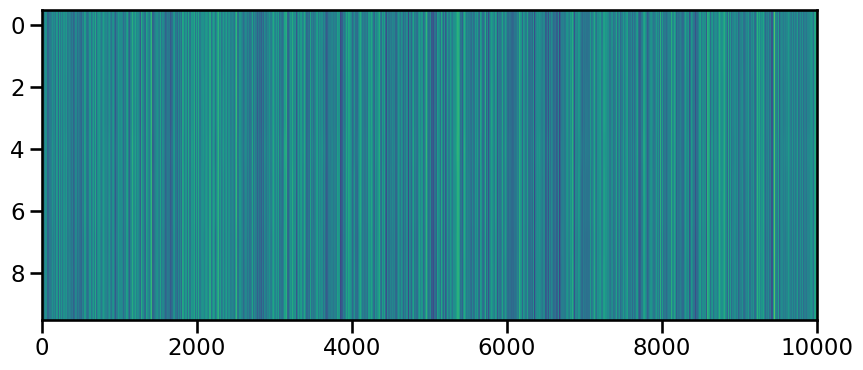

In [28]:
# Increase figure size for better resolution
plt.figure(figsize=(10, 10))  # Increase width and height

plt.imshow(load_transcriptome(dataset='UTSW'), aspect=400)

# Save with high DPI
plt.savefig('ut_image_large.png', dpi=600)

# Show the plot
plt.show()

/scratch/asr655/neuroinformatics
Components: 1, Variance explained: 0.09470952853569295
Components: 2, Variance explained: 0.2101488569849384
Components: 3, Variance explained: 0.33621413935892447
Components: 4, Variance explained: 0.42974945159073563
Components: 5, Variance explained: 0.5338600536190977
Components: 6, Variance explained: 0.6689878876270858
Components: 7, Variance explained: 0.7886321413690143
Components: 8, Variance explained: 0.9026192275142881
Components: 9, Variance explained: 1.0
Components: 10, Variance explained: 1.0


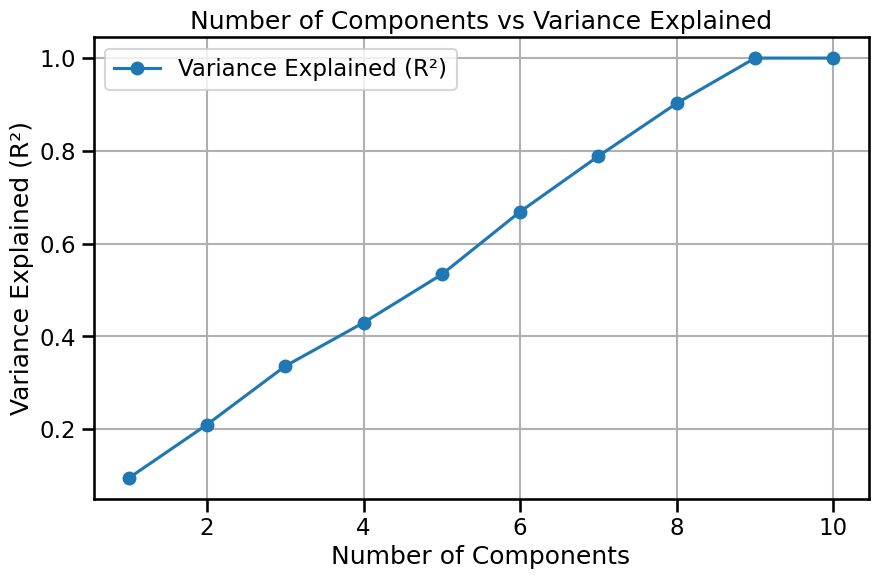

Loaded 10005 gene names.


In [101]:
X = load_transcriptome(dataset='AHBA in UTSW')
Y = load_connectome(dataset='UTSW')

# Step 2: Run PLS for multiple components and get variance explained
max_components = 10
variances_explained = run_pls_for_components(X, Y, max_components)

# Step 3: Plot the number of components vs variance explained
plot_variance_explained(variances_explained, max_components)

ahba_in_utsw_feature_importances_df = get_feature_importances(X, Y, n_components=3, gene_names=load_utsw_gene_names())
ahba_in_utsw_normalized_importances_df = normalize_components(ahba_in_utsw_feature_importances_df)

#### Analysis of subsampled components

In [102]:
# Step 1: Compute the intersected gene names
intersected_genes = compute_gene_name_intersection()

# Step 2: Filter and sort the feature importance DataFrames
ahba_in_gtex_filtered_sorted_df = filter_and_sort_by_genes(ahba_in_gtex_feature_importances_df, intersected_genes)
gtex_filtered_sorted_df = filter_and_sort_by_genes(gtex_feature_importances_df, intersected_genes)
ahba_in_utsw_filtered_sorted_df = filter_and_sort_by_genes(ahba_in_utsw_feature_importances_df, intersected_genes)
utsw_filtered_sorted_df = filter_and_sort_by_genes(utsw_feature_importances_df, intersected_genes)

# Step 3: Display the results (or save them)
print(ahba_in_gtex_filtered_sorted_df.head())
print(gtex_filtered_sorted_df.head())
print(ahba_in_utsw_filtered_sorted_df.head())
print(utsw_filtered_sorted_df.head())

Loaded 11053 gene names.
Loaded 10704 gene names.
Loaded 10005 gene names.
Number of intersected genes: 9888
       Component_1  Component_2  Component_3
A1BG      0.001649    -0.003914    -0.023171
AAAS     -0.012817    -0.012734     0.002441
AACS     -0.012198     0.005039     0.003103
AADAT    -0.007992     0.003483    -0.021726
AAED1     0.006933    -0.014268     0.010417
       Component_1  Component_2  Component_3
A1BG     -0.014281     0.008120     0.000765
AAAS      0.009136    -0.014050    -0.011496
AACS      0.011677    -0.000379     0.008708
AADAT     0.013668     0.005304    -0.015317
AAED1    -0.003705    -0.003495    -0.014424
       Component_1  Component_2  Component_3
A1BG      0.000973     0.008635     0.008390
AAAS     -0.005139    -0.004401     0.015123
AACS      0.000156    -0.004748    -0.007253
AADAT     0.012156    -0.008723    -0.000719
AAED1    -0.013978     0.003125    -0.001411
       Component_1  Component_2  Component_3
A1BG     -0.010167    -0.008973    -

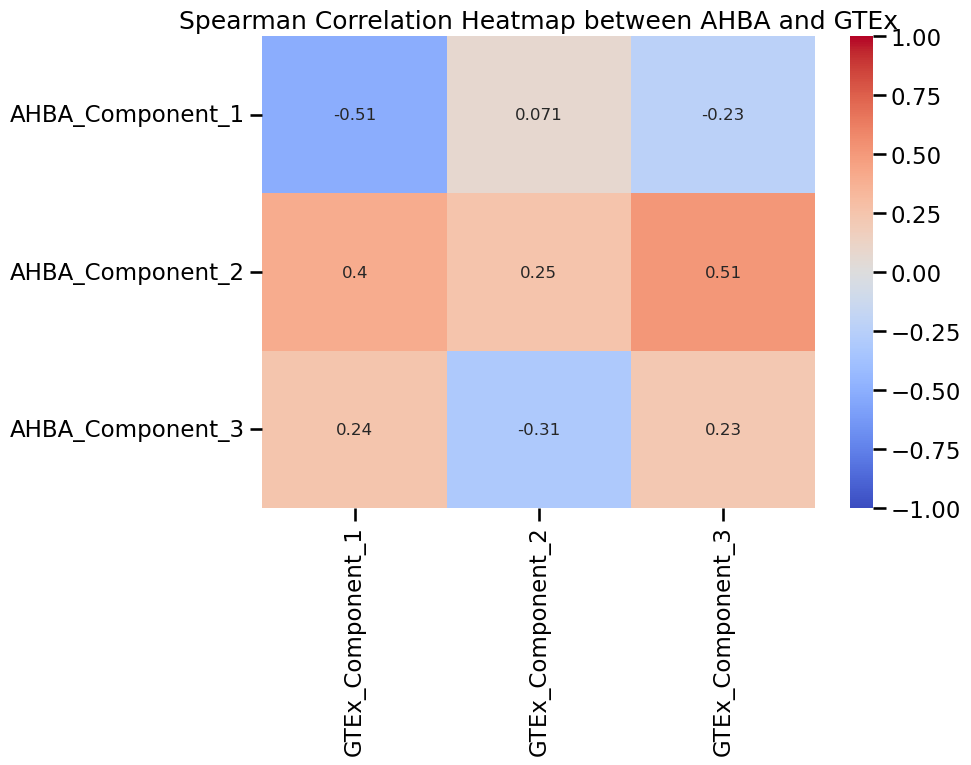

In [116]:
# Step 1: Compute the correlation matrix
correlation_matrix_df = compute_correlation_with_labels(ahba_in_gtex_filtered_sorted_df, gtex_filtered_sorted_df,
                                                        dataset1_name='AHBA', dataset2_name='GTEx', 
                                                        correlation_type='spearman', use_abs=False)

# Step 2: Plot the heatmap
plot_correlation_heatmap(correlation_matrix_df, title='Spearman Correlation Heatmap between AHBA and GTEx')


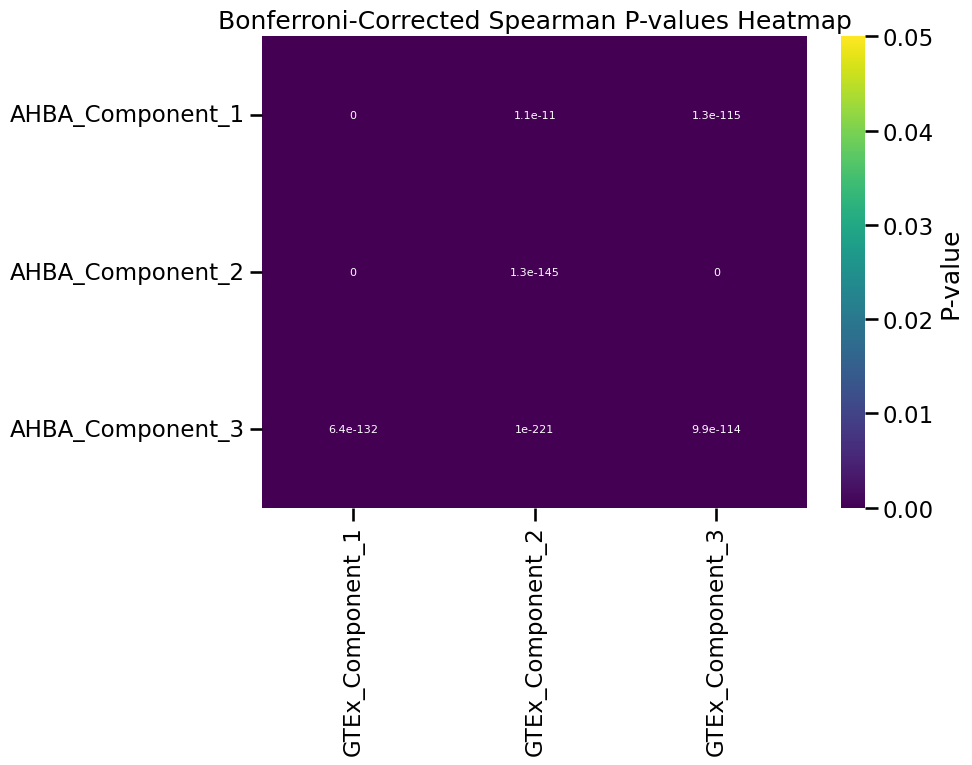

In [117]:
# Step 1: Compute p-values for the correlations across all datasets using Spearman correlation
pvalue_df = compute_correlation_with_pvalues(ahba_in_gtex_filtered_sorted_df, 
                                             gtex_filtered_sorted_df, 
                                             dataset1_name='AHBA', dataset2_name='GTEx', 
                                             correlation_type='spearman', use_abs=False)

# Step 2: Apply Bonferroni correction to the computed p-values
corrected_pvalue_df = apply_bonferroni_correction(pvalue_df)

# Step 3: Plot the Bonferroni-corrected p-value heatmap
plot_pvalue_heatmap(corrected_pvalue_df, title='Bonferroni-Corrected Spearman P-values Heatmap')


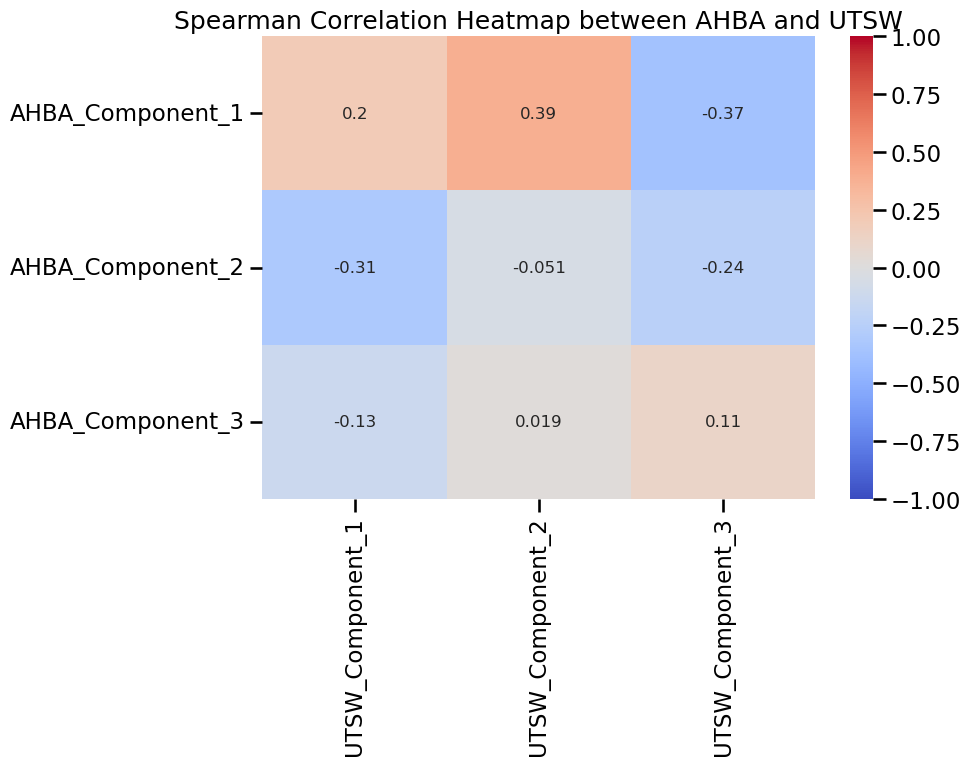

In [120]:
# Step 1: Compute the correlation matrix
correlation_matrix_df = compute_correlation_with_labels(ahba_in_utsw_filtered_sorted_df, utsw_filtered_sorted_df,
                                                        dataset1_name='AHBA', dataset2_name='UTSW', 
                                                        correlation_type='spearman', use_abs=False)

# Step 2: Plot the heatmap
plot_correlation_heatmap(correlation_matrix_df, title='Spearman Correlation Heatmap between AHBA and UTSW')

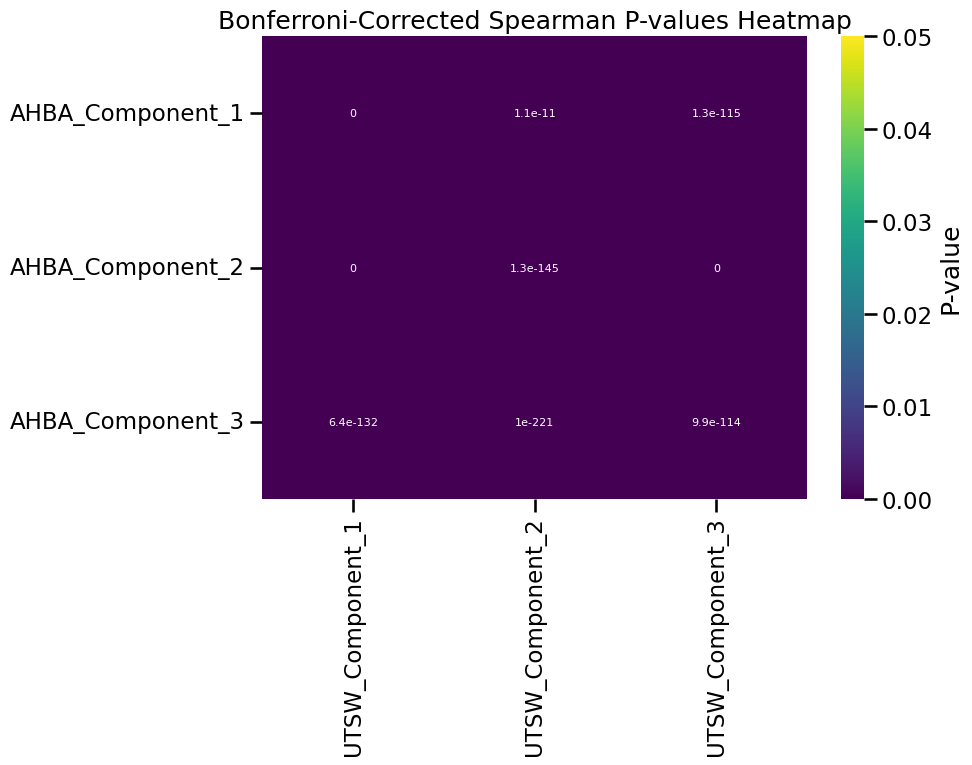

In [121]:
# Step 1: Compute p-values for the correlations across all datasets using Spearman correlation
pvalue_df = compute_correlation_with_pvalues(ahba_in_gtex_filtered_sorted_df, 
                                             gtex_filtered_sorted_df, 
                                             dataset1_name='AHBA', dataset2_name='UTSW', 
                                             correlation_type='spearman', use_abs=False)

# Step 2: Apply Bonferroni correction to the computed p-values
corrected_pvalue_df = apply_bonferroni_correction(pvalue_df)

# Step 3: Plot the Bonferroni-corrected p-value heatmap
plot_pvalue_heatmap(corrected_pvalue_df, title='Bonferroni-Corrected Spearman P-values Heatmap')


In [122]:
# Assuming utsw_feature_importances_df is already defined and loaded
top_5_ahba_per_component = get_top_n_values_per_column(ahba_in_gtex_filtered_sorted_df, n=5)

# Display the top 5 values for each component
for component, df in top_5_ahba_per_component.items():
    print(f"\nTop 5 genes for {component}:")
    print(df)

# Assuming utsw_feature_importances_df is already defined and loaded
top_5_gtex_per_component = get_top_n_values_per_column(gtex_filtered_sorted_df, n=5)

# Display the top 5 values for each component
for component, df in top_5_gtex_per_component.items():
    print(f"\nTop 5 genes for {component}:")
    print(df)



Top 5 genes for Component_1:
            Gene     Value
FAM136A  FAM136A  0.015452
COL5A3    COL5A3 -0.015364
SPA17      SPA17  0.015238
SPATA6L  SPATA6L  0.015194
KIFC2      KIFC2 -0.015191

Top 5 genes for Component_2:
          Gene     Value
MYDGF    MYDGF  0.023903
CCDC57  CCDC57 -0.023475
NUS1      NUS1  0.023191
CIT        CIT -0.023162
TCEAL9  TCEAL9  0.023122

Top 5 genes for Component_3:
          Gene     Value
KDM7A    KDM7A  0.027293
CRYZL1  CRYZL1 -0.026945
TOMM40  TOMM40  0.026843
SUSD1    SUSD1 -0.026631
DPYSL3  DPYSL3 -0.026495

Top 5 genes for Component_1:
              Gene     Value
NLN            NLN  0.015844
METTL21A  METTL21A  0.015747
MYO1B        MYO1B  0.015713
LLPH          LLPH  0.015668
KBTBD2      KBTBD2  0.015665

Top 5 genes for Component_2:
        Gene     Value
DTNA    DTNA  0.031255
GNA12  GNA12  0.031155
NPAS3  NPAS3  0.030124
NUPR2  NUPR2  0.029857
CDH4    CDH4  0.029760

Top 5 genes for Component_3:
            Gene     Value
MEIS3P1  MEIS3P1 -0

In [123]:
# Assuming utsw_feature_importances_df is already defined and loaded
top_5_ahba_per_component = get_top_n_values_per_column(ahba_in_utsw_filtered_sorted_df, n=5)

# Display the top 5 values for each component
for component, df in top_5_ahba_per_component.items():
    print(f"\nTop 5 genes for {component}:")
    print(df)

# Assuming utsw_feature_importances_df is already defined and loaded
top_5_utsw_per_component = get_top_n_values_per_column(utsw_filtered_sorted_df, n=5)

# Display the top 5 values for each component
for component, df in top_5_utsw_per_component.items():
    print(f"\nTop 5 genes for {component}:")
    print(df)


Top 5 genes for Component_1:
            Gene     Value
MNAT1      MNAT1  0.016726
EPCAM      EPCAM -0.016675
GPCPD1    GPCPD1  0.016640
ARHGDIB  ARHGDIB  0.016630
CORO6      CORO6 -0.016583

Top 5 genes for Component_2:
              Gene     Value
HCP5          HCP5  0.025589
LONRF2      LONRF2 -0.025394
SEC11A      SEC11A  0.024843
ARHGAP19  ARHGAP19  0.024827
OLFML2B    OLFML2B  0.024737

Top 5 genes for Component_3:
          Gene     Value
DHX9      DHX9  0.033987
ARFIP2  ARFIP2 -0.032357
GSK3A    GSK3A -0.031899
NFIA      NFIA -0.031816
HRH2      HRH2  0.031476

Top 5 genes for Component_1:
              Gene     Value
NMT2          NMT2  0.017746
ZBTB38      ZBTB38  0.017623
SLC39A12  SLC39A12 -0.017619
PSPH          PSPH  0.017564
BHLHE22    BHLHE22  0.017549

Top 5 genes for Component_2:
              Gene     Value
TRIM26      TRIM26  0.022186
INTU          INTU -0.021855
ADNP-AS1  ADNP-AS1  0.021805
KCNG3        KCNG3 -0.021707
TASP1        TASP1 -0.021701

Top 5 genes for

#### Analysis of full dataset components (not subsampled)

In [57]:
# Step 1: Compute the intersected gene names
intersected_genes = compute_gene_name_intersection()

# Step 2: Filter and sort the feature importance DataFrames
ahba_filtered_sorted_df = filter_and_sort_by_genes(ahba_feature_importances_df, intersected_genes)
gtex_filtered_sorted_df = filter_and_sort_by_genes(gtex_feature_importances_df, intersected_genes)
utsw_filtered_sorted_df = filter_and_sort_by_genes(utsw_feature_importances_df, intersected_genes)

# Step 3: Display the results (or save them)
print(ahba_filtered_sorted_df.head())  # Check the first few rows
print(gtex_filtered_sorted_df.head())
print(utsw_filtered_sorted_df.head())

Loaded 11053 gene names.
Loaded 10704 gene names.
Loaded 10005 gene names.
Number of intersected genes: 9888
       Component_1  Component_2  Component_3
A1BG     -0.010853     0.010779     0.008289
AAAS      0.008836    -0.009938     0.000574
AACS      0.013549     0.006949     0.002022
AADAT     0.008383    -0.001006     0.011122
AAED1    -0.010731     0.003559    -0.002743
       Component_1  Component_2  Component_3
A1BG     -0.014281     0.008120     0.000765
AAAS      0.009136    -0.014050    -0.011496
AACS      0.011677    -0.000379     0.008708
AADAT     0.013668     0.005304    -0.015317
AAED1    -0.003705    -0.003495    -0.014424
       Component_1  Component_2  Component_3
A1BG     -0.010167    -0.008973    -0.007658
AAAS     -0.006713     0.004892     0.006996
AACS      0.006239    -0.014569     0.006949
AADAT     0.005016     0.008296    -0.013648
AAED1    -0.011901    -0.012899     0.006549


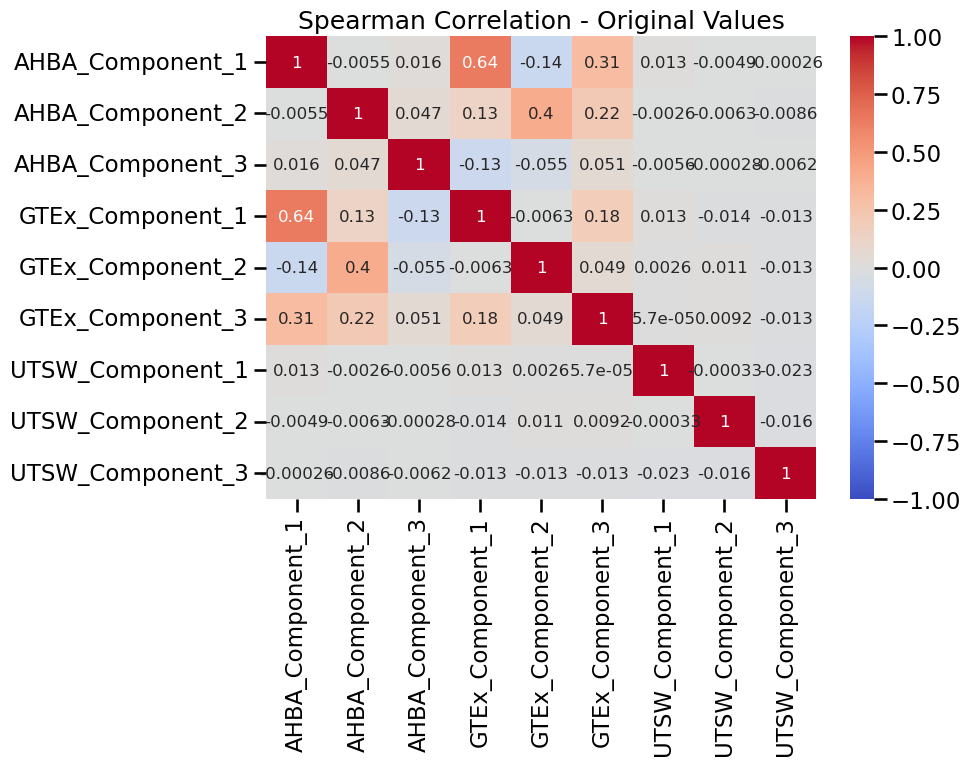

In [82]:
# Step 1: Compute correlations for the original values across all datasets using Spearman correlation
spearman_correlation_df = compute_correlation_across_datasets(
    ahba_filtered_sorted_df, 
    gtex_filtered_sorted_df, 
    utsw_filtered_sorted_df,
    correlation_type='spearman', 
    use_abs=False
)

# Step 2: Plot the Spearman correlation heatmap
plot_correlation_heatmap(spearman_correlation_df, title='Spearman Correlation - Original Values')

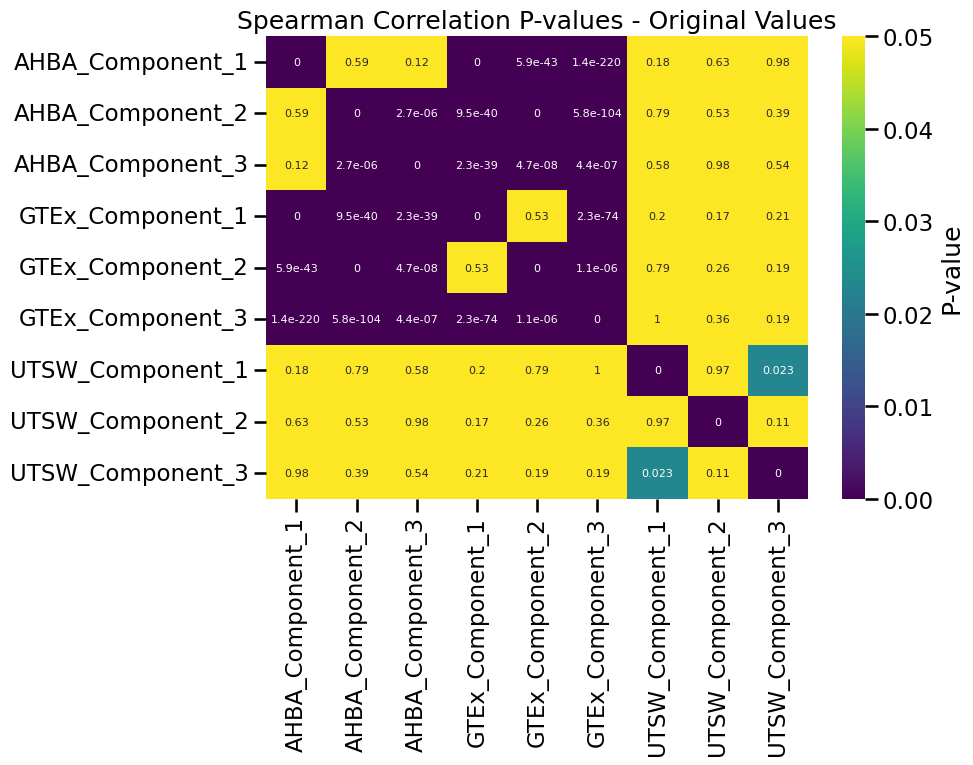

In [83]:
# Step 1: Compute p-values for the correlations across all datasets using Spearman correlation
spearman_pvalue_df = compute_correlation_pvalues_across_datasets(
    ahba_filtered_sorted_df, 
    gtex_filtered_sorted_df, 
    utsw_filtered_sorted_df, 
    correlation_type='spearman', 
    use_abs=False
)

# Step 2: Plot the Spearman correlation p-value heatmap
plot_pvalue_heatmap(spearman_pvalue_df, title='Spearman Correlation P-values - Original Values')

#https://stats.stackexchange.com/questions/55288/understanding-the-p-value-in-spearmans-rank-correlation

# Step 1: Compute p-values for the correlations across all datasets using Spearman correlation
spearman_pvalue_df = compute_correlation_pvalues_across_datasets(
    ahba_filtered_sorted_df, 
    gtex_filtered_sorted_df, 
    utsw_filtered_sorted_df, 
    correlation_type='spearman', 
    use_abs=False
)

# Step 2: Apply Bonferroni correction to the computed p-values
corrected_spearman_pvalue_df = apply_bonferroni_correction(spearman_pvalue_df)

# Step 3: Plot the Bonferroni-adjusted p-value heatmap
plot_pvalue_heatmap(corrected_spearman_pvalue_df, title='Bonferroni-Corrected Spearman Correlation P-values')


In [108]:
# Assuming utsw_feature_importances_df is already defined and loaded
top_5_ahba_per_component = get_top_n_values_per_column(ahba_feature_importances_df, n=5)

# Display the top 5 values for each component
for component, df in top_5_ahba_per_component.items():
    print(f"\nTop 5 genes for {component}:")
    print(df)


Top 5 genes for Component_1:
          Gene     Value
COX7A1  COX7A1  0.016773
HEBP1    HEBP1 -0.016674
ECM1      ECM1  0.016516
CABP1    CABP1  0.016378
NKAIN4  NKAIN4 -0.016350

Top 5 genes for Component_2:
          Gene     Value
CAPN12  CAPN12  0.028804
NEB        NEB -0.027031
CDH8      CDH8  0.026358
NT5DC2  NT5DC2  0.025896
BAIAP3  BAIAP3  0.025871

Top 5 genes for Component_3:
          Gene     Value
KYNU      KYNU  0.045405
OPN4      OPN4  0.041695
SNHG18  SNHG18  0.038434
LIPC      LIPC  0.036351
UST        UST -0.036268


In [109]:
# Assuming utsw_feature_importances_df is already defined and loaded
top_5_gtex_per_component = get_top_n_values_per_column(gtex_feature_importances_df, n=5)

# Display the top 5 values for each component
for component, df in top_5_gtex_per_component.items():
    print(f"\nTop 5 genes for {component}:")
    print(df)


Top 5 genes for Component_1:
              Gene     Value
NCOA4        NCOA4  0.015880
NLN            NLN  0.015844
METTL21A  METTL21A  0.015747
MYO1B        MYO1B  0.015713
LLPH          LLPH  0.015668

Top 5 genes for Component_2:
        Gene     Value
DTNA    DTNA  0.031255
GNA12  GNA12  0.031155
HES5    HES5  0.030700
NPAS3  NPAS3  0.030124
NUPR2  NUPR2  0.029857

Top 5 genes for Component_3:
                Gene     Value
C14orf177  C14orf177  0.029626
MEIS3P1      MEIS3P1 -0.029338
RAB29          RAB29 -0.029302
TGDS            TGDS -0.029286
AK3              AK3 -0.029134


In [107]:
# Assuming utsw_feature_importances_df is already defined and loaded
top_5_utsw_per_component = get_top_n_values_per_column(utsw_feature_importances_df, n=5)

# Display the top 5 values for each component
for component, df in top_5_utsw_per_component.items():
    print(f"\nTop 5 genes for {component}:")
    print(df)


Top 5 genes for Component_1:
              Gene     Value
NMT2          NMT2  0.017746
ZBTB38      ZBTB38  0.017623
SLC39A12  SLC39A12 -0.017619
PSPH          PSPH  0.017564
BHLHE22    BHLHE22  0.017549

Top 5 genes for Component_2:
              Gene     Value
TRIM26      TRIM26  0.022186
INTU          INTU -0.021855
ADNP-AS1  ADNP-AS1  0.021805
KCNG3        KCNG3 -0.021707
TASP1        TASP1 -0.021701

Top 5 genes for Component_3:
          Gene     Value
DAPK1    DAPK1  0.028529
PLAGL1  PLAGL1 -0.027713
VANGL1  VANGL1  0.027242
PHLDA3  PHLDA3  0.027121
BCL2L1  BCL2L1 -0.026954


### PREDICTION ANALYSIS

### AHBA PLS <a id="PLS-Sims"></a>

#### 4-Fold Random split

In [44]:
full_pls_random_shared_sim_results = multi_sim_run('random',
                                                'pls',
                                                use_gpu=False, 
                                                use_shared_regions=False, 
                                                test_shared_regions=False, 
                                                save_sim=True,
                                                search_method='grid'
                                                )


Number of components explaining 95% of the variance: 34

 Test fold num: 1
(7140, 170) (7140,) (812, 170) (812,)
2
3
4
Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END max_iter=1000, n_components=1, scale=True, tol=1e-07; total time=   0.0s[CV] END max_iter=1000, n_components=1, scale=False, tol=1e-07; total time=   0.1s
[CV] END max_iter=1000, n_components=3, scale=False, tol=1e-07; total time=   0.1s

[CV] END max_iter=1000, n_components=5, scale=True, tol=1e-07; total time=   0.1s
[CV] END max_iter=1000, n_components=3, scale=True, tol=1e-07; total time=   0.2s
[CV] END max_iter=1000, n_components=5, scale=False, tol=1e-07; total time=   0.1s
[CV] END max_iter=1000, n_components=7, scale=False, tol=1e-07; total time=   0.1s
[CV] END max_iter=1000, n_components=7, scale=True, tol=1e-07; total time=   0.1s
[CV] END max_iter=1000, n_components=9, scale=False, tol=1e-07; total time=   0.1s
[CV] END max_iter=1000, n_components=9, scale=True, tol=1e-07; total time=   

In [129]:
multi_sim_random_pls = open_pickled_results('multi_sim_random_pls.pickle')

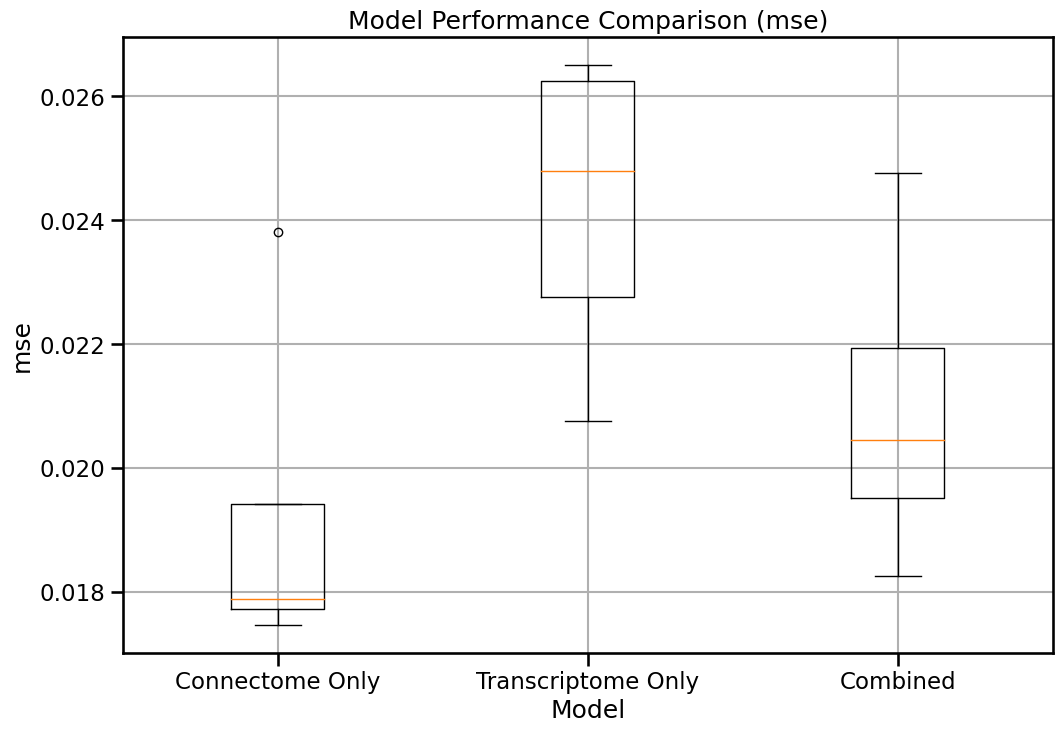

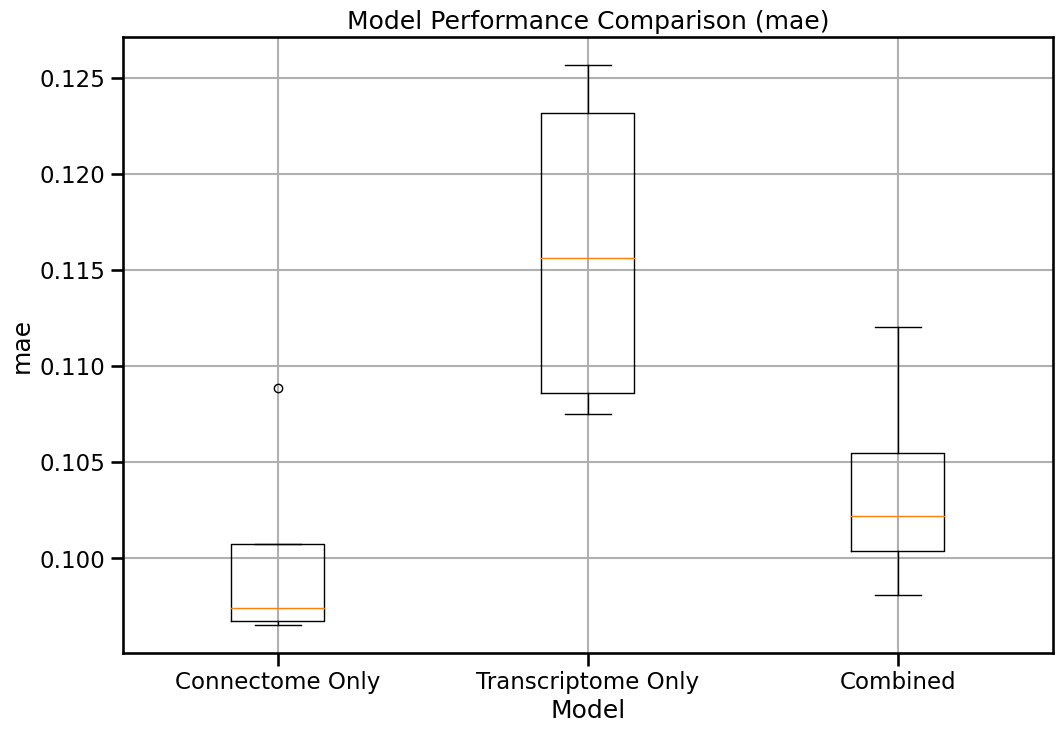

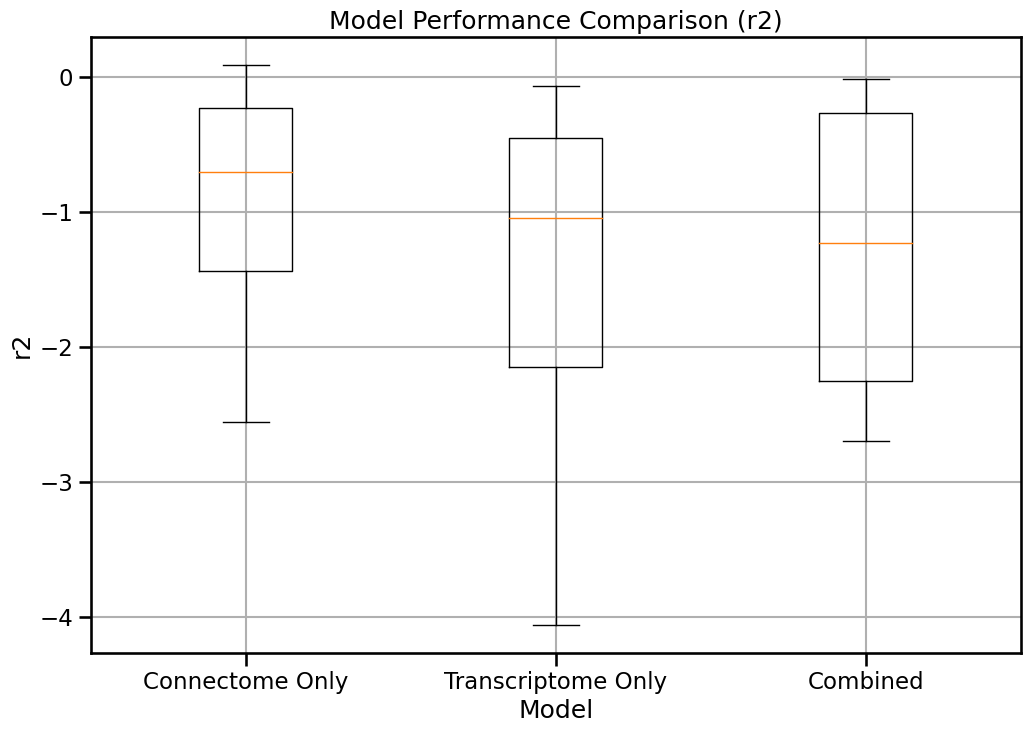

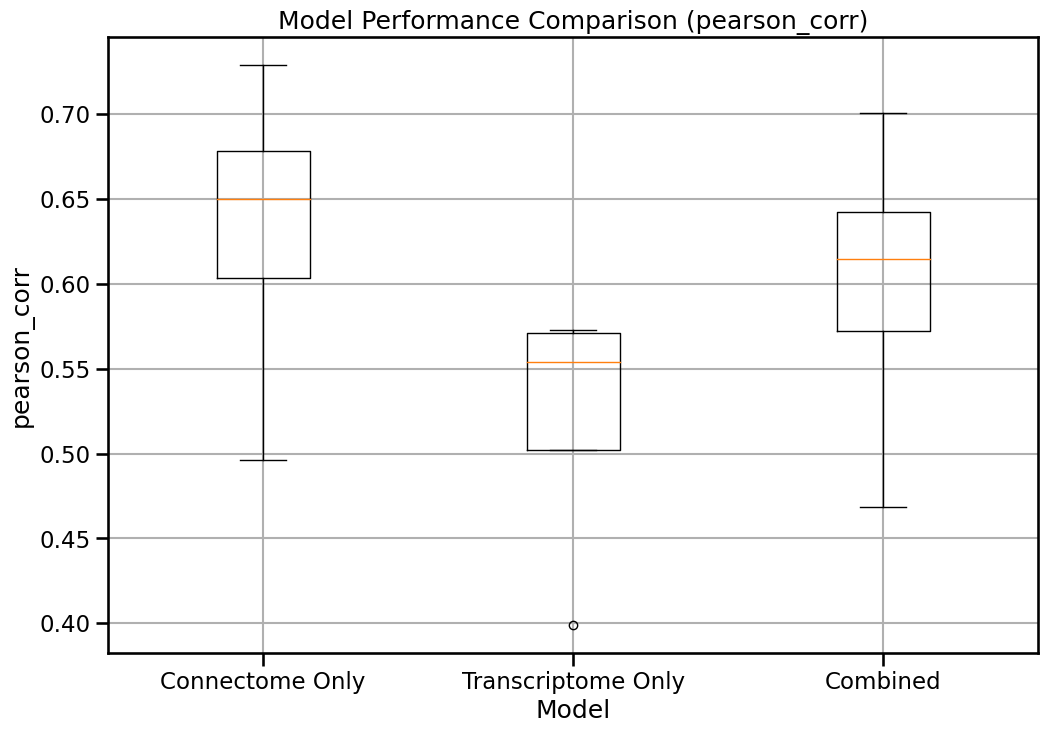

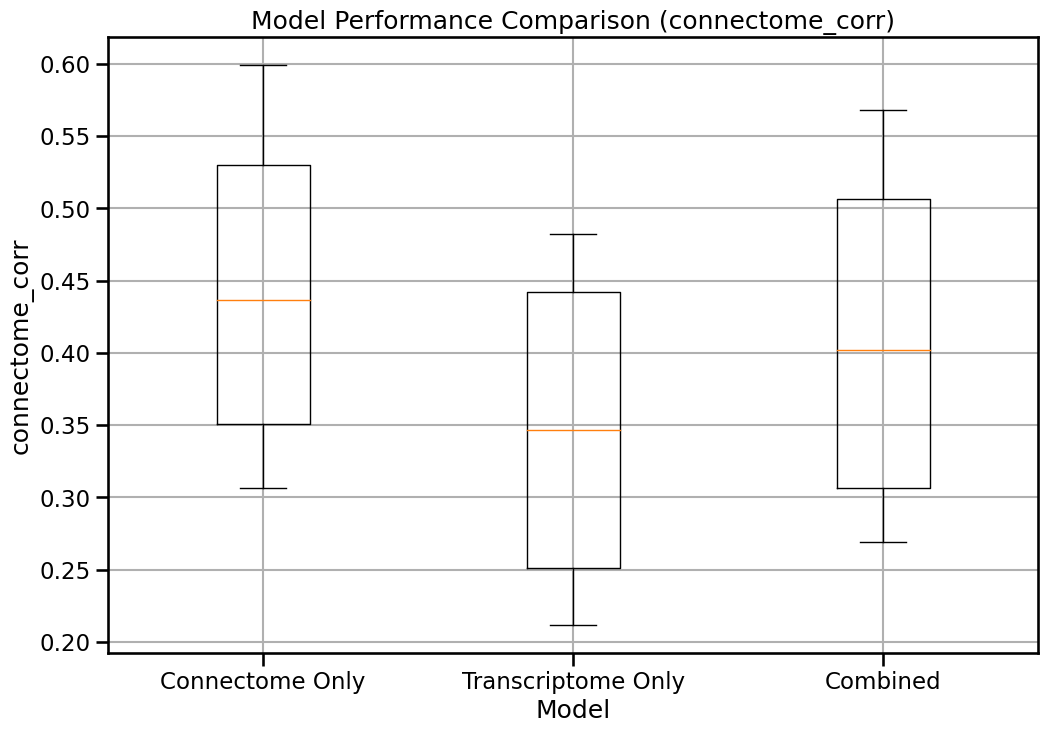

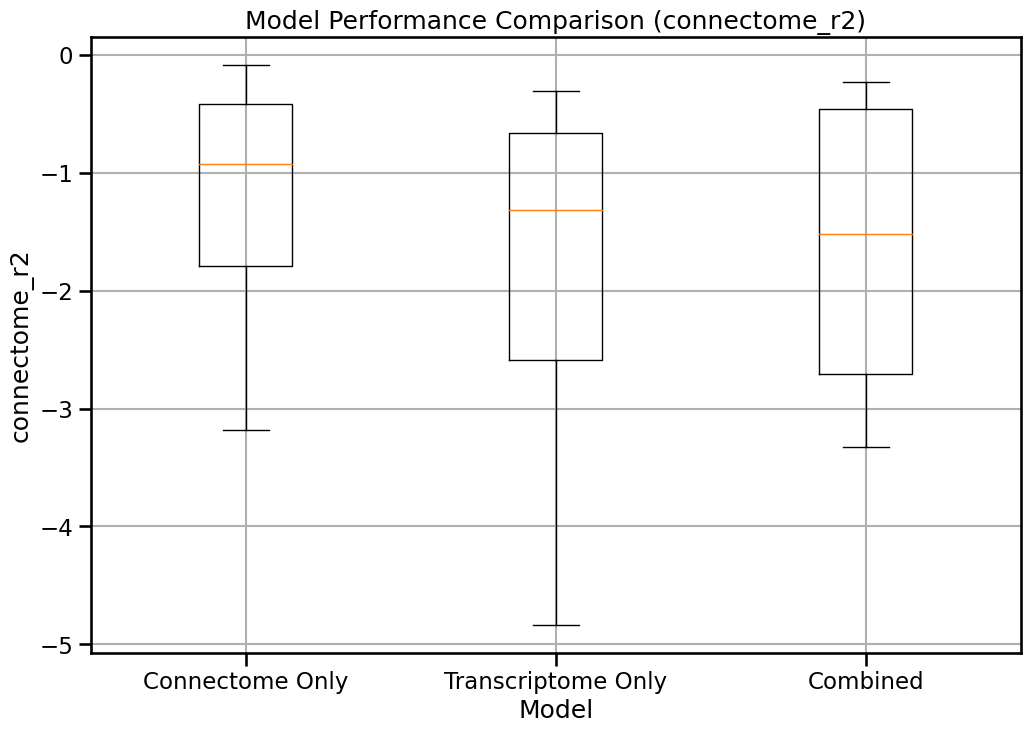

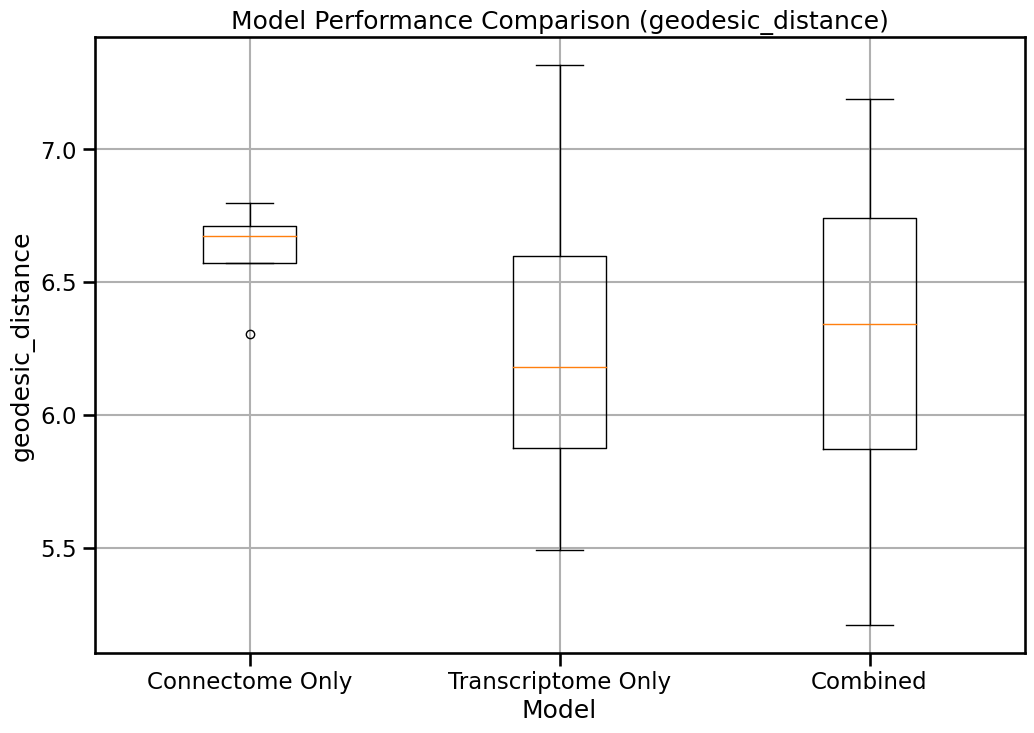

In [130]:
boxplot_model_performance(multi_sim_random_pls)

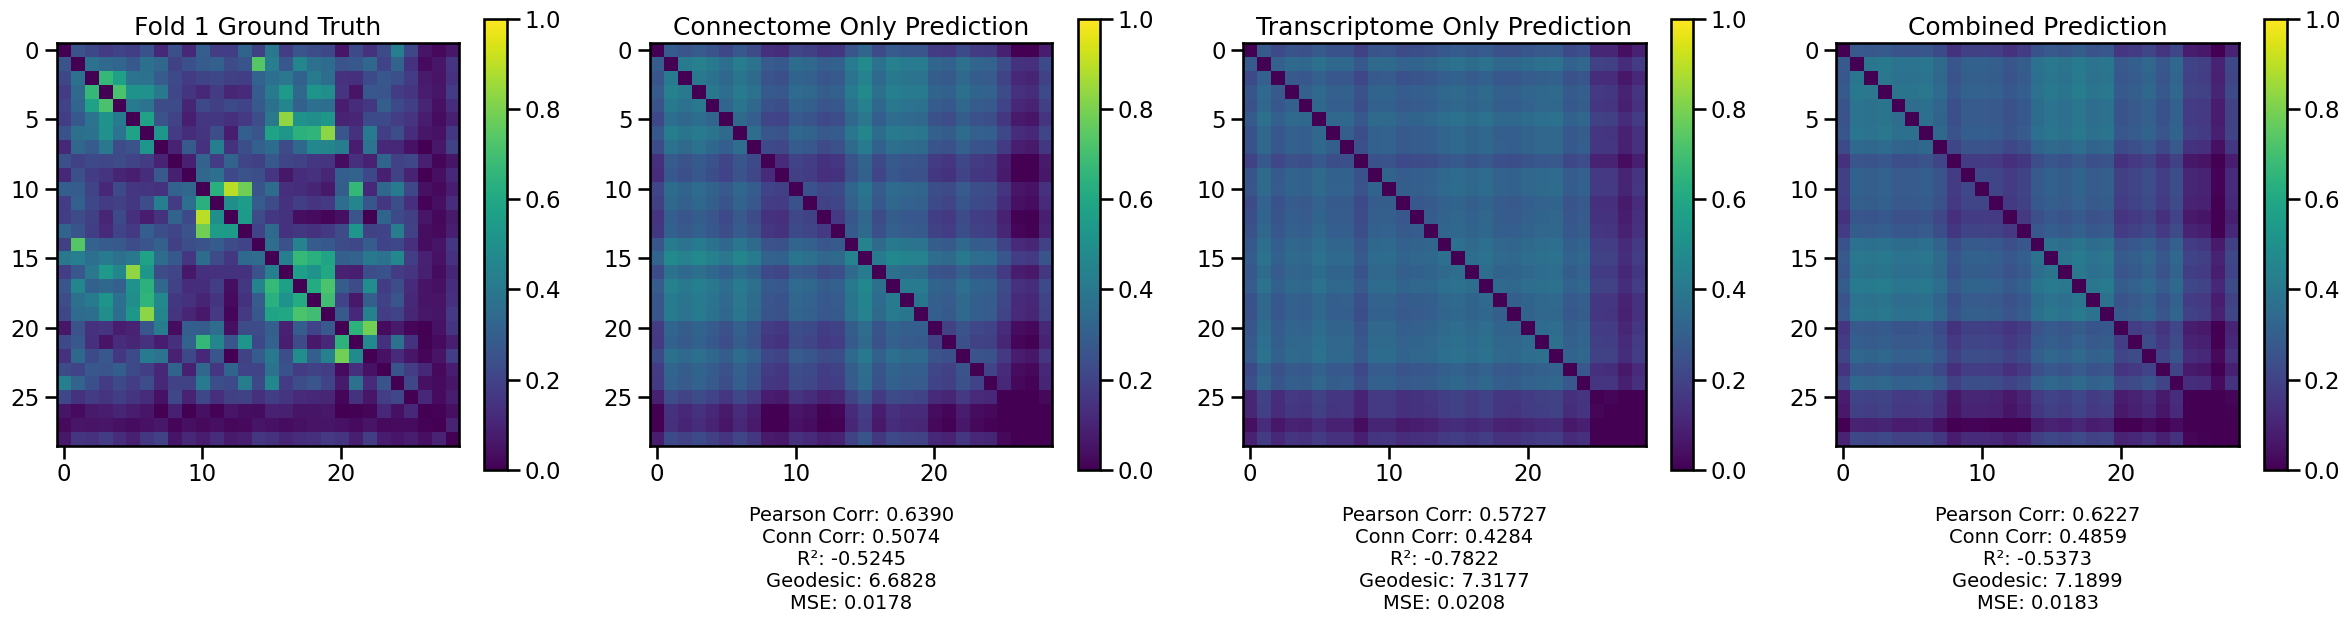

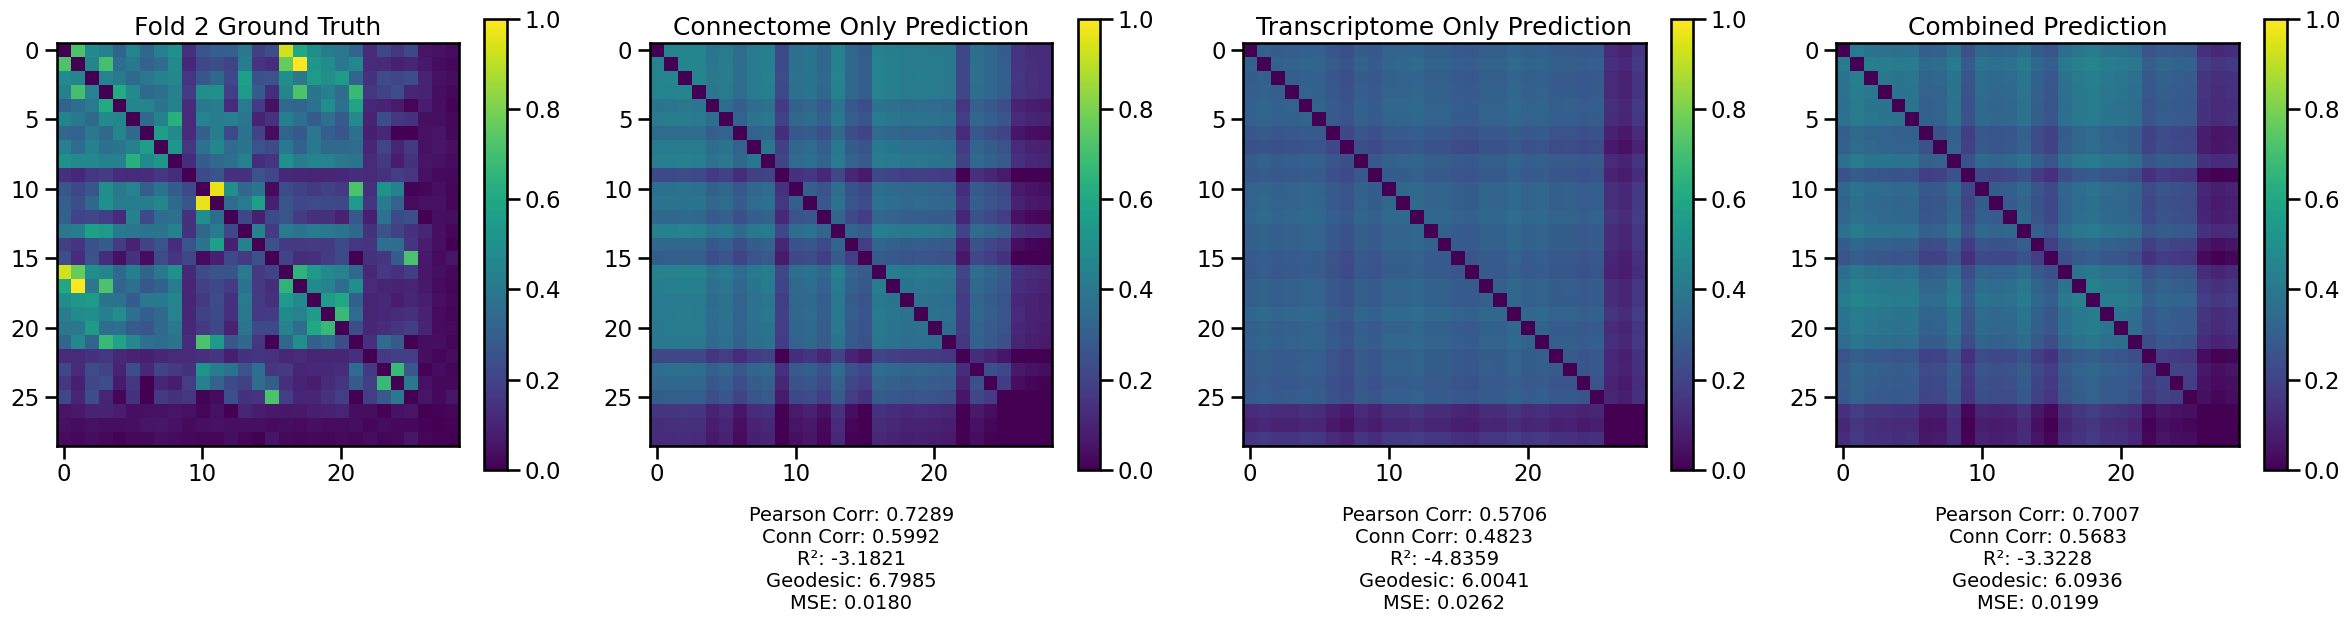

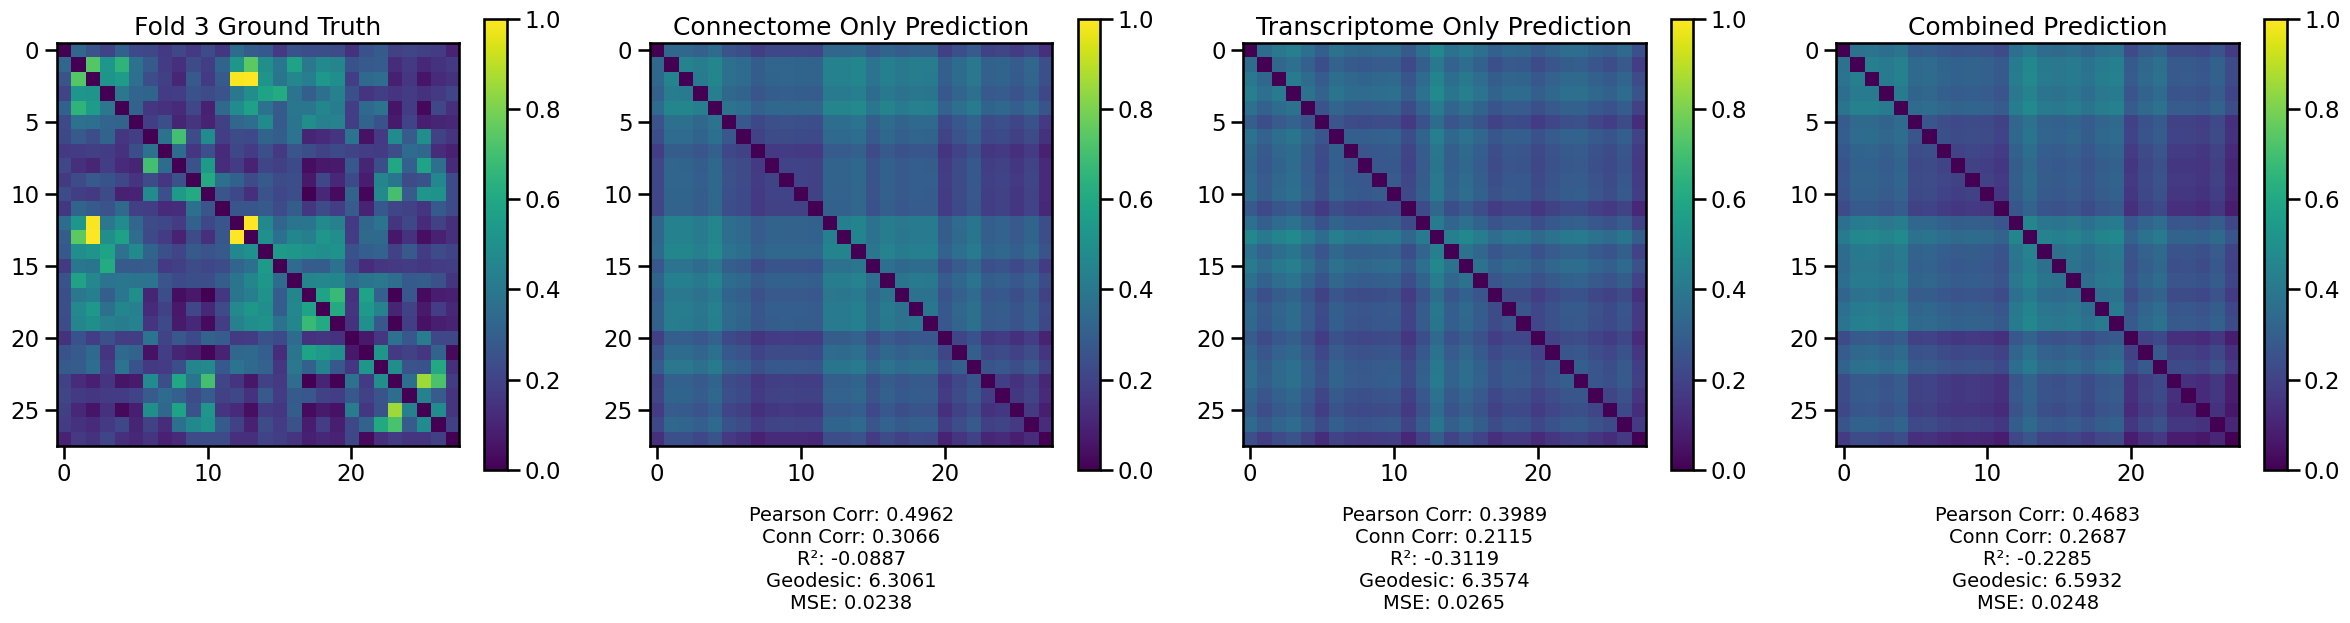

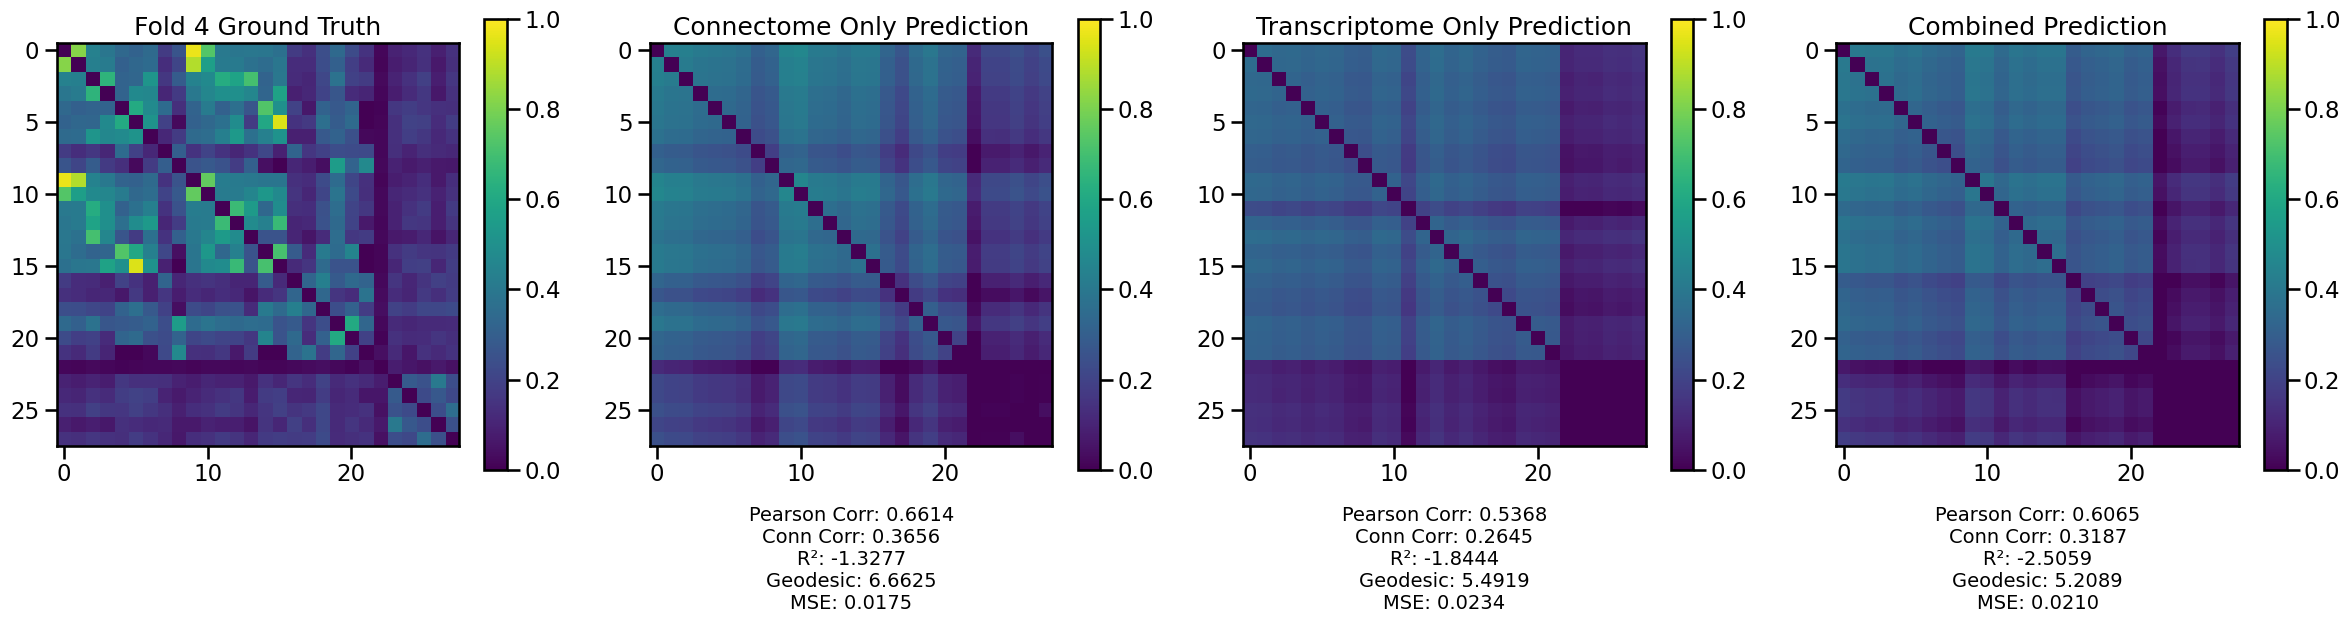

In [131]:
plot_predictions_with_metrics(multi_sim_random_pls)

### AHBA XGBoost <a id="XGBoost-Sims"></a>

#### 4-Fold Random split

Random split, trained on non-shared regions, test on non-shared

In [8]:
full_xgb_random_nonshared_sim_results = multi_sim_run('random',
                                              'xgboost',
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False, 
                                              save_sim=True,
                                              search_method='random'
                                              )

Number of components explaining 95% of the variance: 34

 Test fold num: 1
(7140, 170) (7140,) (812, 170) (812,)
2
3
4


CUDARuntimeError: cudaErrorNoDevice: no CUDA-capable device is detected

In [11]:
trans_xgb_random_nonshared_sim_results = single_sim_run(cv_type='random',
                                              model_type='xgboost',
                                              feature_type='trans only',
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False, 
                                              save_sim=True,
                                              search_method='bayes'
                                              )

Number of components explaining 95% of the variance: 34
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(7140, 22106) (7140,) (812, 22106) (812,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
ACCELERATING
{'base_estimator': 'GP', 'acq_func': 'PI'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.01, subsample=1, tree_method=gpu_hist, verbosity=0;, score=0.481 total time=   2.2s
[CV 2/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0.01, subsample=1, tree_method=gpu_hist, verbosity=0;, score=0.351 total time=   2.2s
[CV 3/3] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=4, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0

In [10]:
transplusconn_xgb_random_nonshared_sim_results = single_sim_run(cv_type='random',
                                              model_type='xgboost',
                                              feature_type='trans plus conn',
                                              use_gpu=True,
                                              use_shared_regions=False,
                                              test_shared_regions=False, 
                                              save_sim=True,
                                              search_method='random'
                                              )

Number of components explaining 95% of the variance: 34
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(7140, 22276) (7140,) (812, 22276) (812,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
Fitting 1 folds for each of 100 candidates, totalling 100 fits
[CV 1/1] END colsample_bytree=0.8, device=cuda, learning_rate=0.3, max_depth=5, n_estimators=250, n_gpus=-1, random_state=42, reg_alpha=0, reg_lambda=0, subsample=0.8, tree_method=gpu_hist, verbosity=0;, score=0.780 total time=   2.7s
[CV 1/1] END colsample_bytree=1, device=cuda, learning_rate=0.1, max_depth=2, n_estimators=350, n_gpus=-1, random_state=42, reg_alpha=1, reg_lambda=0, subsample=0.8, tree_method=gpu_hist, verbosity=0;, score=0.817 total time=   1.5s
[CV 1/1] END colsample_bytree=0.8, device=cuda, learning_rate=0.1, max_depth=4, n_estimators=150, n_gpus=-1, random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=0.8, tree_method=gpu_hist, verbosi

Functions to combine single sim results

In [22]:
# File names
conn_file = 'single_sim_conn_random_xgboost.pickle'
# trans_file = 'single_sim_trans_rsearch_random_xgboost.pickle'
trans_file = 'single_sim_trans_bsearch_random_xgboost.pickle'
transconn_file = 'single_sim_transplusconn_random_xgboost.pickle'
output_file = 'multi_sim_random_xgboost_combined.pickle'

# Combine the results
combine_results(conn_file, trans_file, transconn_file, output_file)

Combined results saved to ./sim/sim_results/multi_sim_random_xgboost_combined.pickle


In [134]:
multi_sim_random_xgb = open_pickled_results('multi_sim_random_xgboost_combined.pickle')

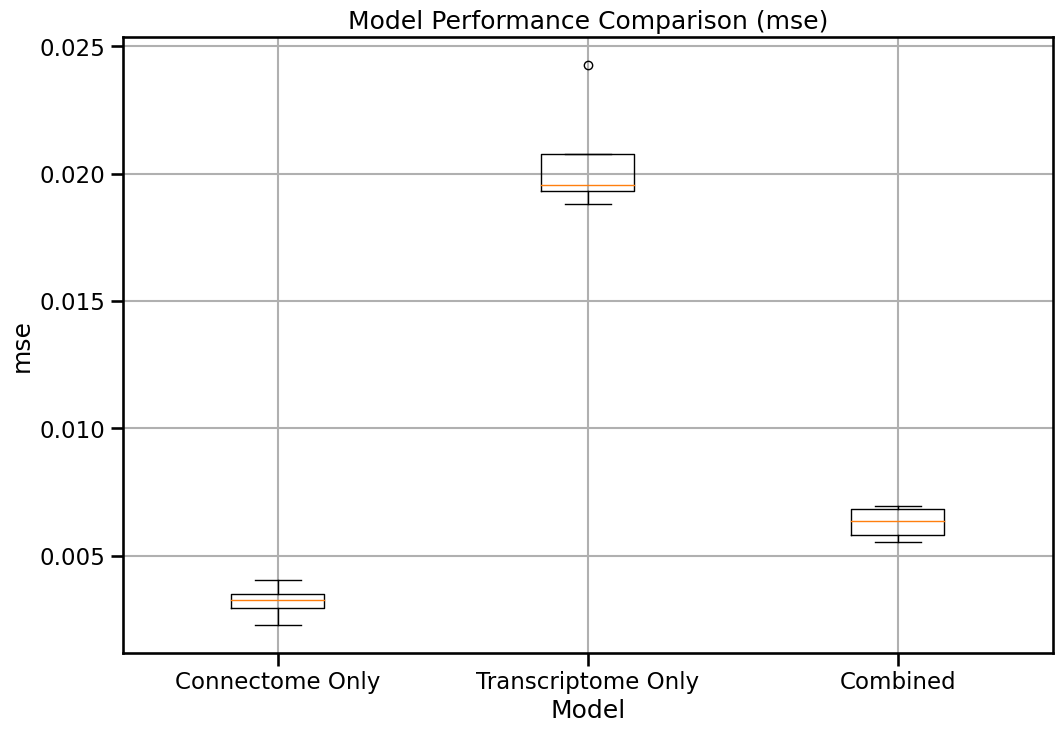

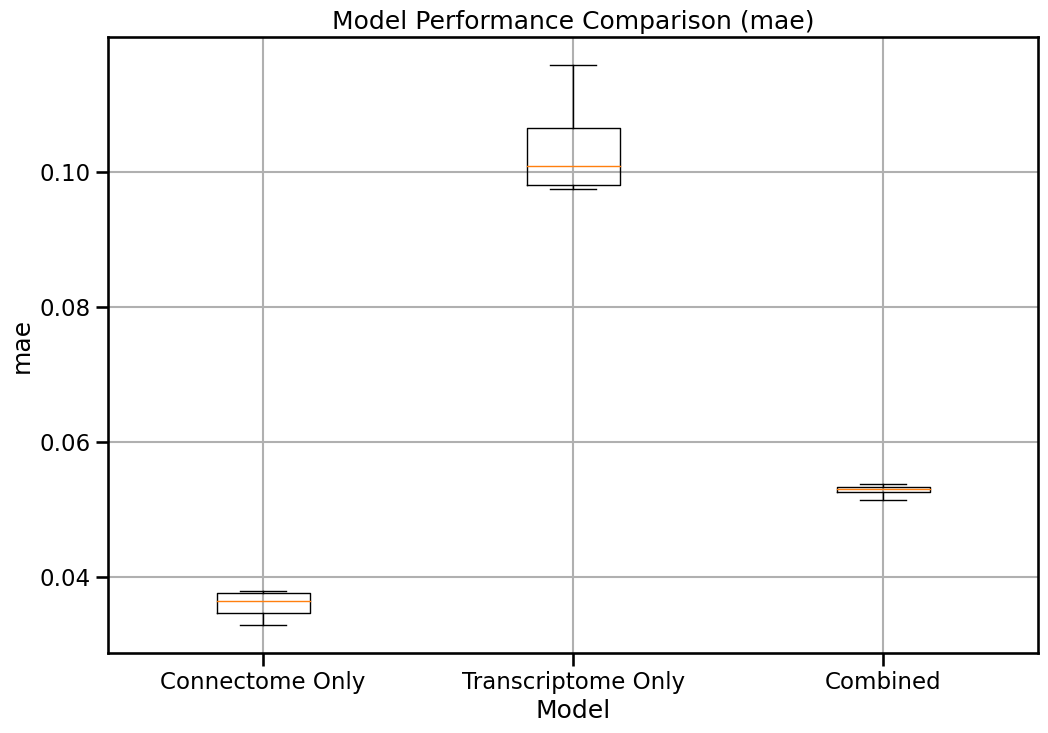

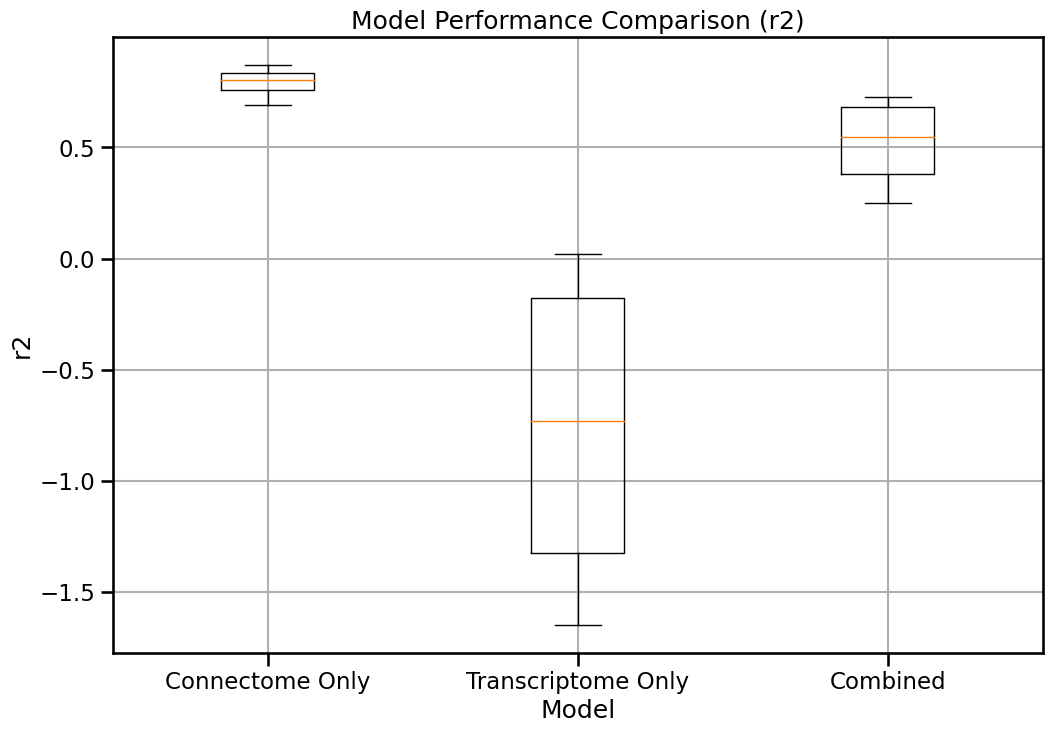

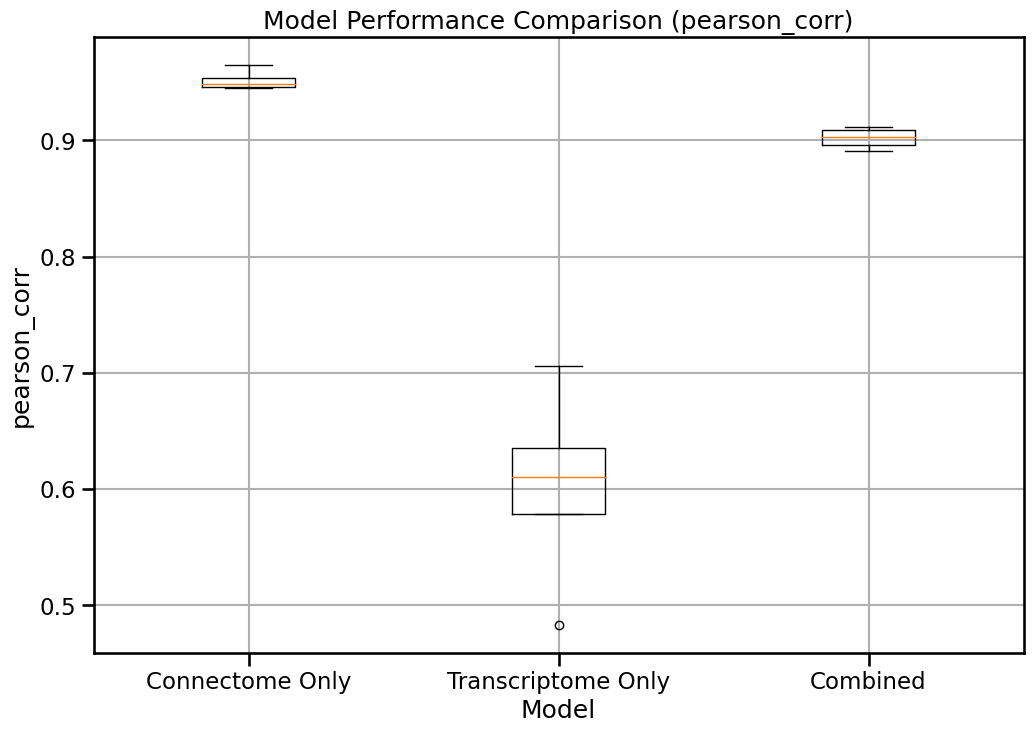

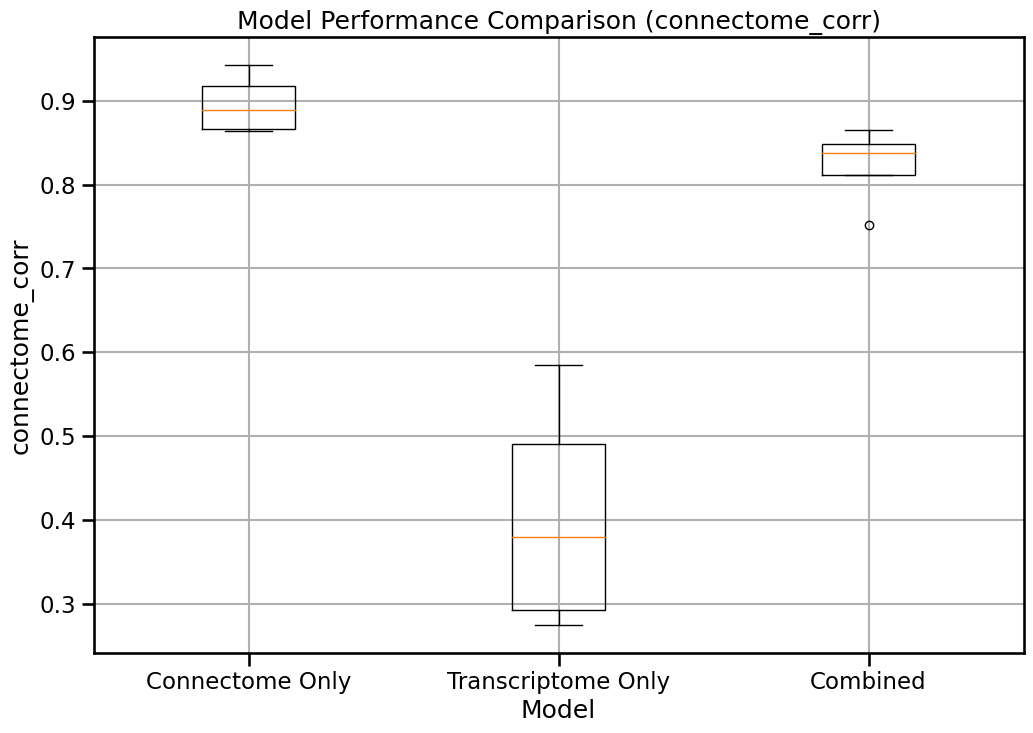

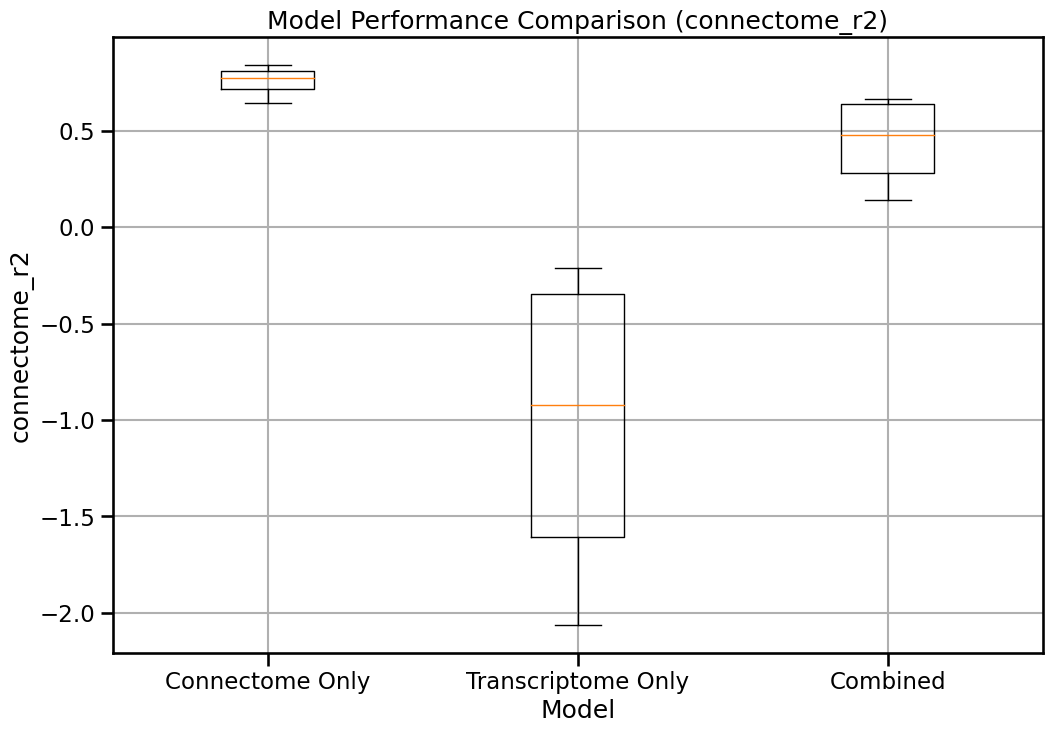

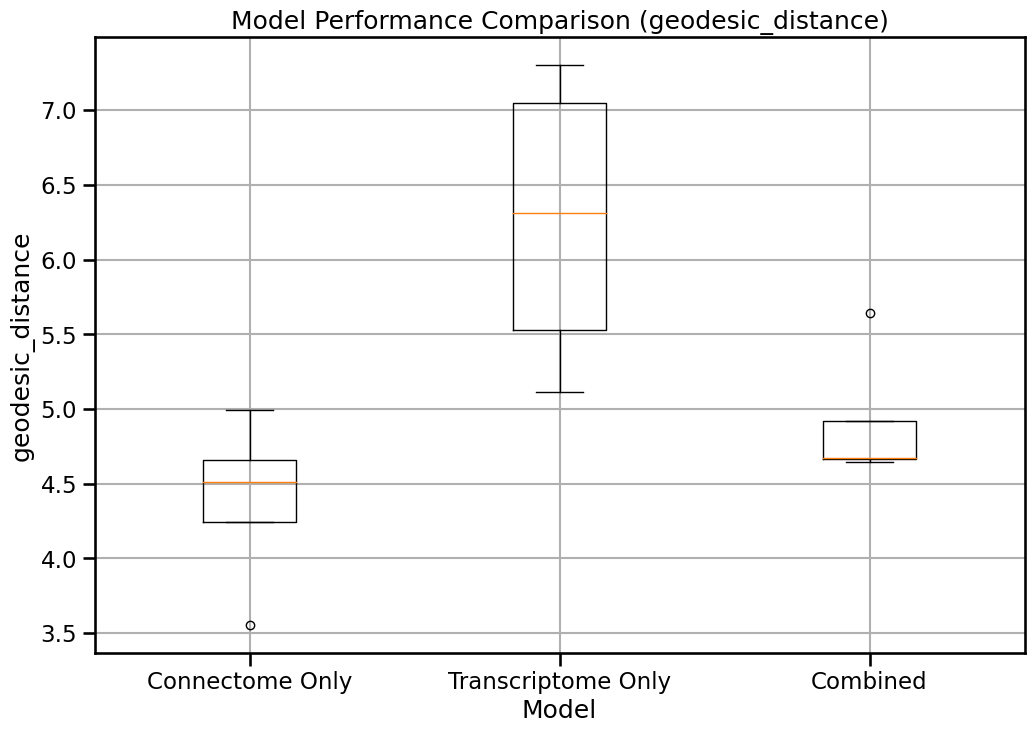

In [135]:
boxplot_model_performance(multi_sim_random_xgb)

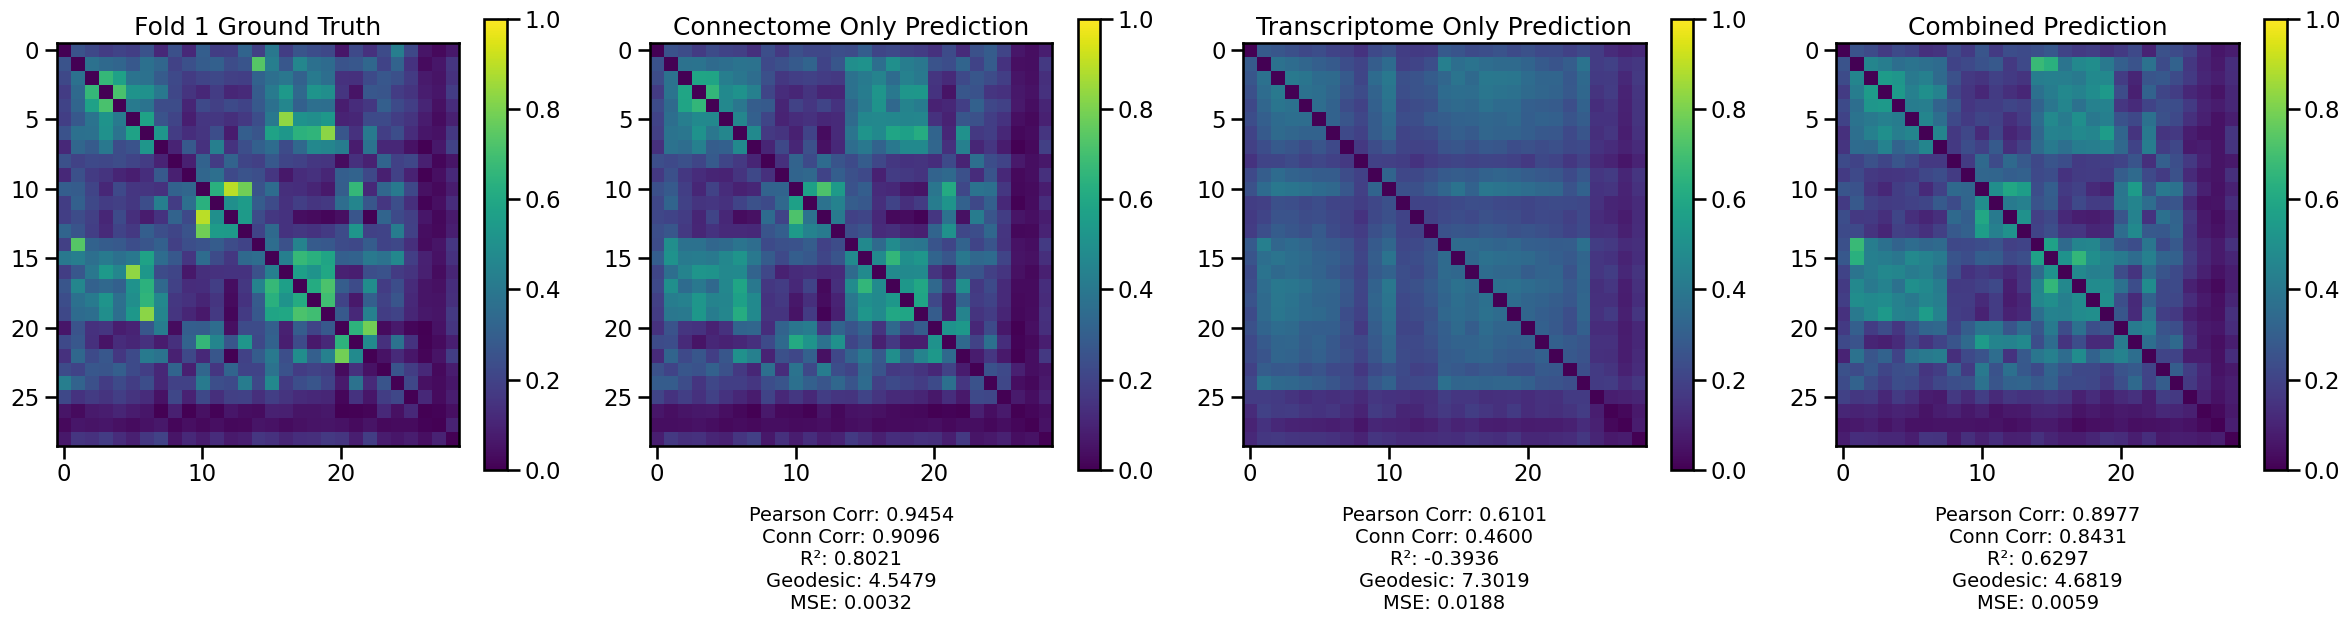

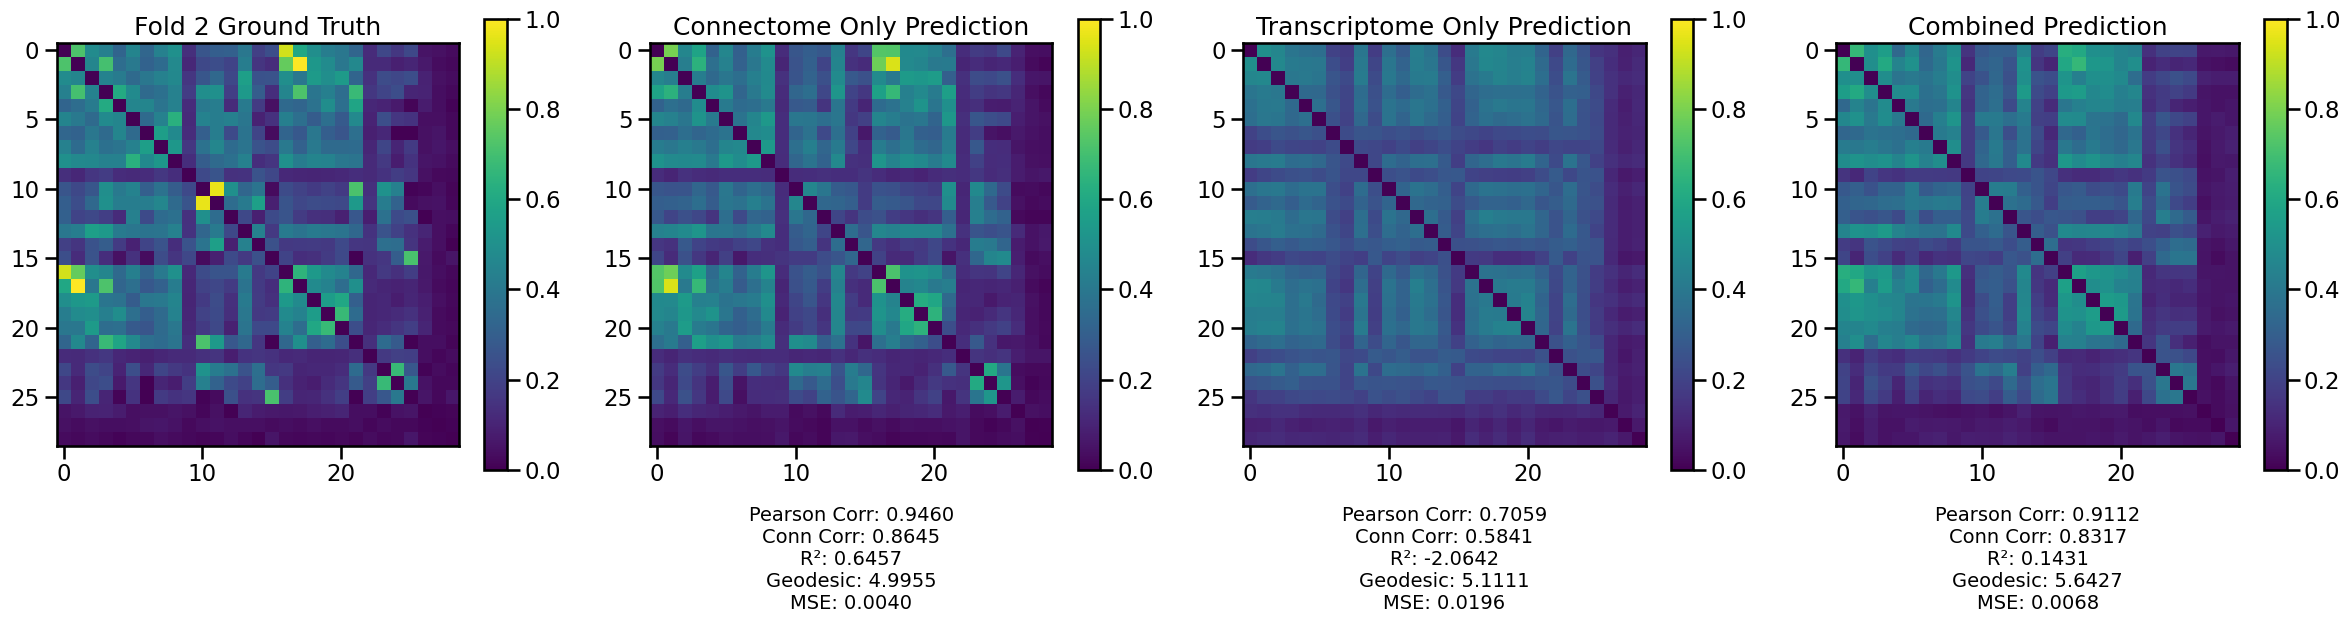

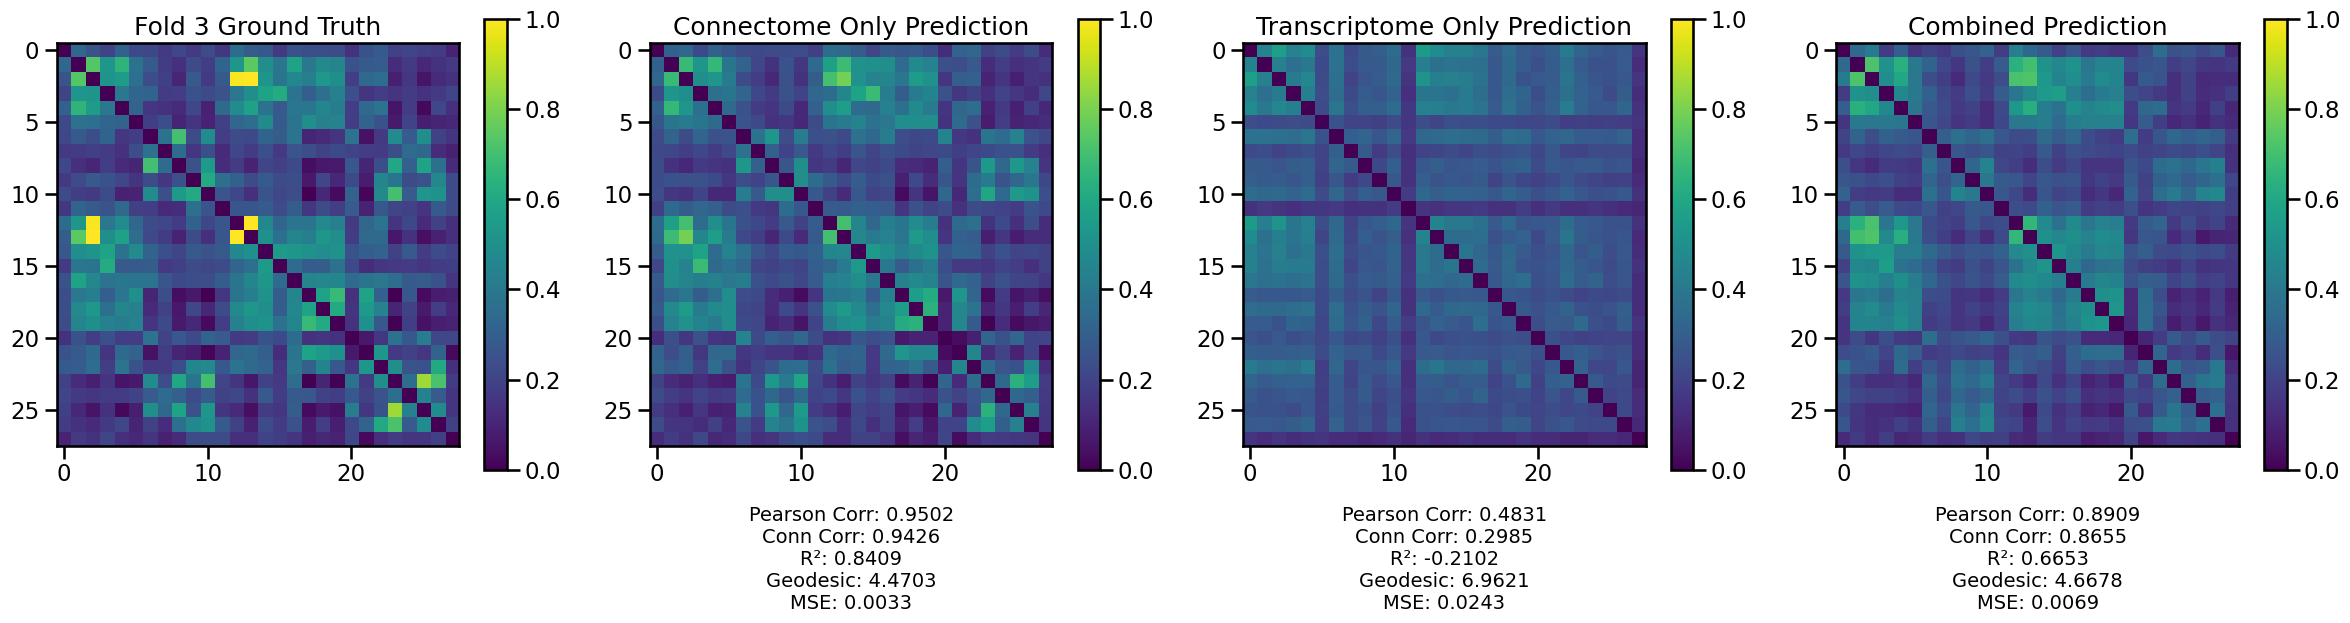

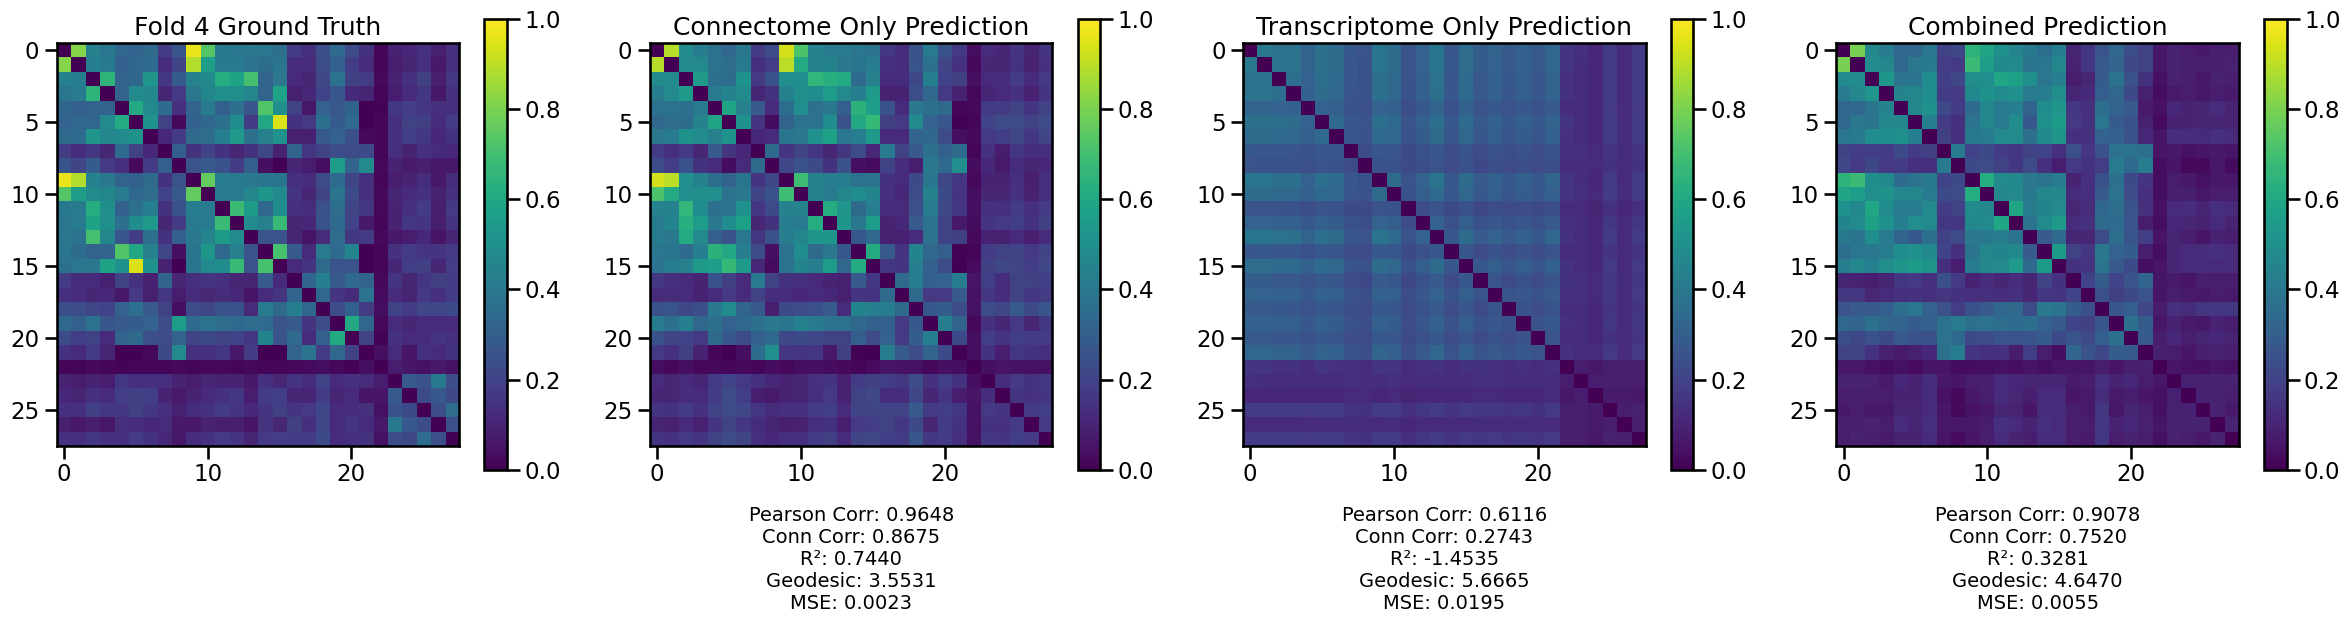

In [136]:
plot_predictions_with_metrics(multi_sim_random_xgb)

High accuracy transcriptome replication

In [ ]:
# This is the high accuracy replication
trans_xgb_random_nonshared_sim_results = single_sim_run(cv_type='random',
                                              model_type='xgboost',
                                              feature_type='trans only',
                                              use_gpu=True,
                                              use_shared_regions=True,
                                              test_shared_regions=False, 
                                              save_sim=True,
                                              search_method='bayes'
                                              )

Number of components explaining 95% of the variance: 34
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...

 Test fold num: 1
(12070, 22106) (12070,) (812, 22106) (812,)
2
3
4
Processing fold 0...
Processing fold 1...
Processing fold 2...
ACCELERATING


In [96]:
trans_sim_random_shared_xgb = multi_sim_run.open_pickled_results('single_sim_trans_bsearch_random_xgboost_useshared_trainshared.pickle')

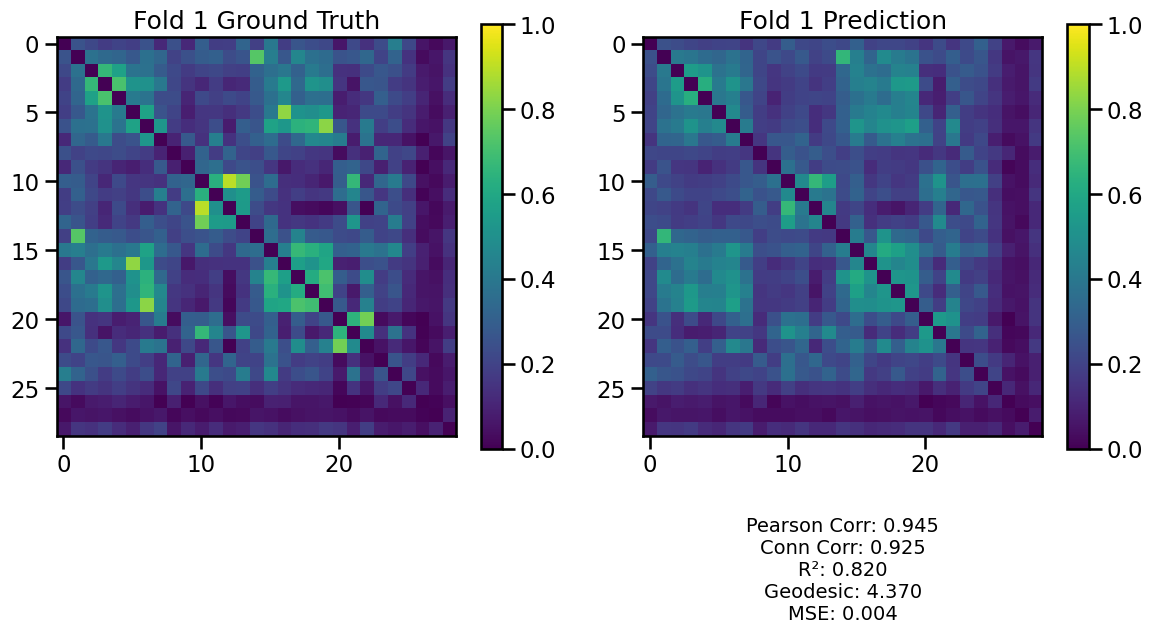

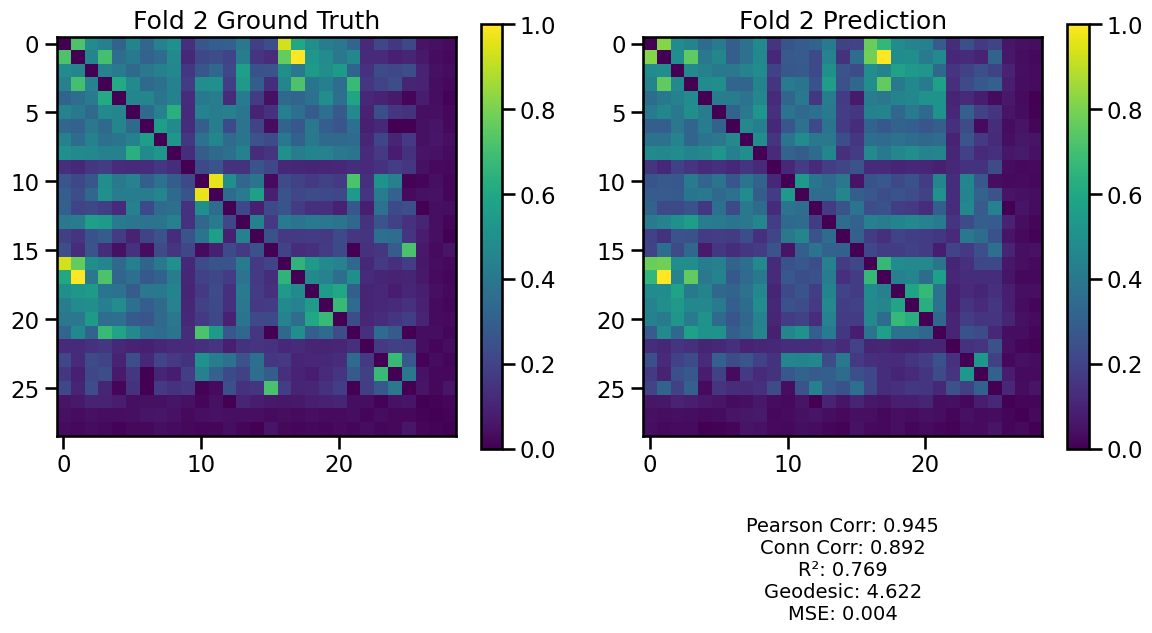

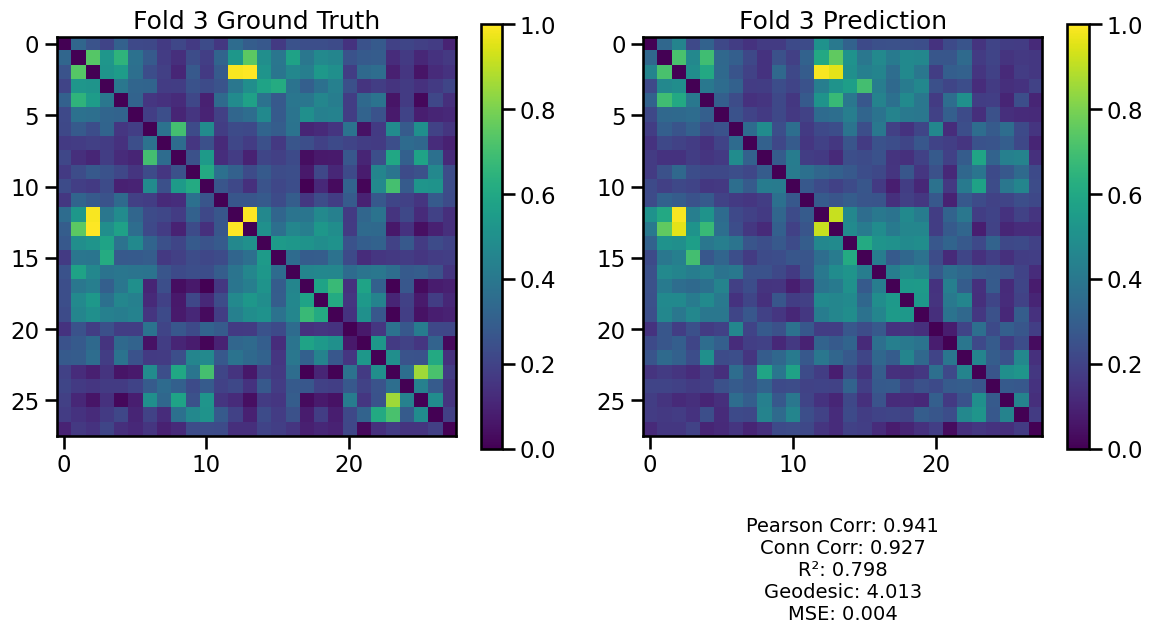

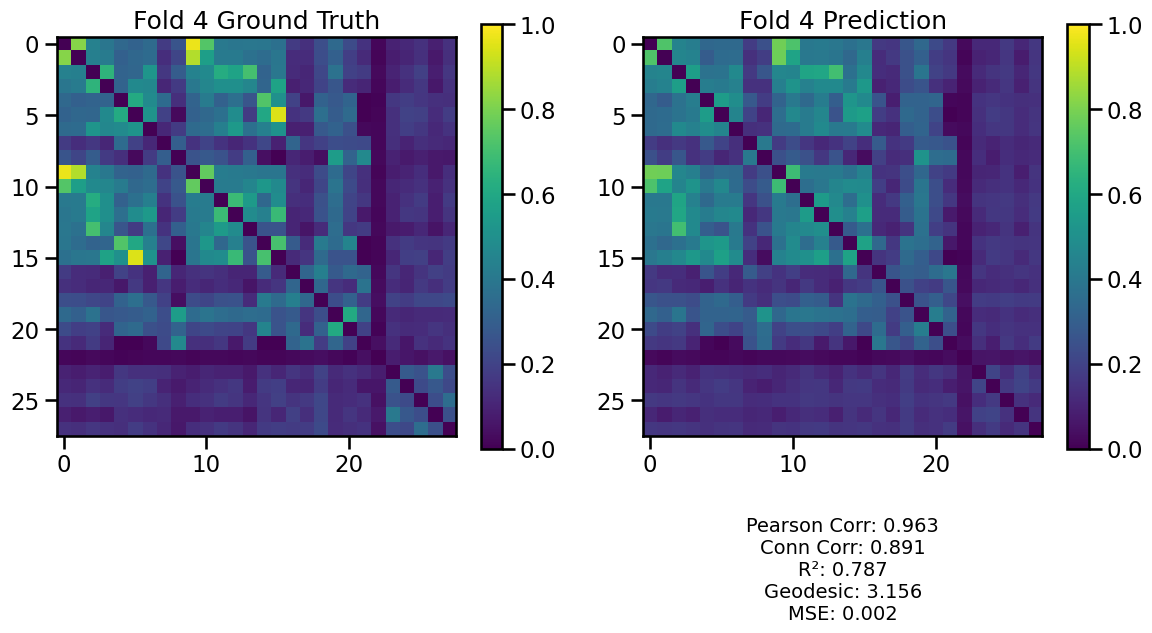

In [99]:
plot.plot_single_model_predictions_with_metrics(trans_sim_random_shared_xgb)